In [1]:
import numpy as np
import cv2
import timeit
import matplotlib.pyplot as plt
import glob

In [2]:
def getAbsoluteScale(f, frame_id):
    ''' Gets the Euclideian distance between the current ground thruth and the former ground thruth.'''
    x_pre, y_pre, z_pre = f[frame_id-1][3], f[frame_id-1][7], f[frame_id-1][11]
    x    , y    , z     = f[frame_id][3], f[frame_id][7], f[frame_id][11]
    scale = np.sqrt((x-x_pre)**2 + (y-y_pre)**2 + (z-z_pre)**2)
    return x, y, z, scale
      
def featureTracking(img_1, img_2, p1):

    lk_params = dict( winSize  = (21,21),
                      maxLevel = 3,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
    
    ## Only Keep matching points
    st = st.reshape(st.shape[0])
    p1 = p1[st==1]
    p2 = p2[st==1]

    return p1,p2

def featureDetection():
    fast=cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
    return fast

def GetGroundTruth(file='/home/Desktop/KITTI VO/poses/06.txt'):
    return np.genfromtxt(file,dtype=None,delimiter='')

def getImages(i):
    return cv2.imread('/home/amar/Documents/DataSets/KittiDataset/2011_09_26/2011_09_26_drive_0009_sync/image_00/data{0:06d}.png'.format(i), 0)

def getK():
    return   np.array([[7.188560000000e+02, 0, 6.071928000000e+02],
              [0, 7.188560000000e+02, 1.852157000000e+02],
              [0, 0, 1]])


def LoadInData(InputPath,Extention=''):
    stuff=[]
    for file in sorted(glob.glob(f'{InputPath}/*{Extention}')):
        img=cv2.imread(file,0)
        stuff.append(img)
    return stuff

In [3]:
# load data


LeftImagePath=r'08/image_0'
GroundTruthFile=r'08.txt'
                                      
LeftDataSet=LoadInData(LeftImagePath,'.png')
ground_truth =GetGroundTruth(GroundTruthFile)

In [4]:
# Set Paramters 

#Camera parameters
fc = 718.8560
pp = (607.1928, 185.2157)
K  = getK()

#initialize some parameters
MAX_FRAME 	  = len(LeftDataSet)
MIN_NUM_FEAT  = 2000

detector = featureDetection()

traj = np.zeros((600, 600, 3), dtype=np.uint8) 

maxError = 0
totalError=0
EuclidanError=np.zeros(len(LeftDataSet))
AvarageError=np.zeros(len(LeftDataSet))

In [5]:
#initialization

gray_1 = LeftDataSet[0]
gray_2 = LeftDataSet[1]

#find the KeyPoints

p1       = detector.detect(gray_1)
p1       = np.array([ele.pt for ele in p1],dtype='float32')
p1, p2   = featureTracking(gray_1, gray_2, p1)

# Essential Matrix Decompastion

E, mask = cv2.findEssentialMat(p2, p1, fc, pp, cv2.RANSAC,0.999,1.0,None); 
_, R, t, mask = cv2.recoverPose(E, p2, p1,focal=fc, pp = pp);

# T1 ->T

preFeature = p2
preImage   = gray_2

# Update Trajectory

R_f = R
T = t


# Main Loop
MAX_FRAME=len(LeftDataSet)-10
for numFrame in range(2, MAX_FRAME):


    if (len(preFeature) < MIN_NUM_FEAT):
        feature   = detector.detect(preImage)
        preFeature = np.array([ele.pt for ele in feature],dtype='float32')


    curImage =LeftDataSet[numFrame]

    
    kp1 = detector.detect(curImage);
    preFeature, curFeature = featureTracking(preImage, curImage, preFeature)
    E, mask = cv2.findEssentialMat(curFeature, preFeature, fc, pp, cv2.RANSAC,0.999,1.0); 
    _, R, t, mask = cv2.recoverPose(E, curFeature, preFeature, focal=fc, pp = pp);

    truth_x, truth_y, truth_z, absolute_scale = getAbsoluteScale(ground_truth, numFrame)

    if absolute_scale > 0.1:  
        T = T + absolute_scale*R_f.dot(t)
        R_f = R.dot(R_f)

    preImage, preFeature = curImage, curFeature
    
    
    # Error Caculation
    curError = np.sqrt((T[0]-truth_x)**2 + (T[1]-truth_y)**2 + (T[2]-truth_z)**2)
    totalError+=curError
    EuclidanError[numFrame]=curError
    
    
    
    if (curError > maxError): maxError = curError
        

    # Visualization of the result
    draw_x, draw_y = int(0.5*T[0]) + 300, int(0.5*T[2]) + 100;
    draw_tx, draw_ty = int(0.5*truth_x) + 300, int(0.5*truth_z) + 100



    cv2.circle(traj, (draw_x, draw_y) ,1, (0,0,255), 2);
    cv2.circle(traj, (draw_tx, draw_ty) ,1, (255,0,0), 2);

    cv2.rectangle(traj, (10, 30), (550, 50), (0,0,0), cv2.FILLED);
    text = f"Coordinates: x ={str(float(T[0]))[0:7]}m y = {str(float(T[2]))[0:7]}m"  
    cv2.putText(traj, text, (10,50), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1, 8);


    cv2.imshow( "Trajectory", traj );
    WK=cv2.waitKey(30)
    if numFrame==len(LeftDataSet)-1:WK=cv2.waitKey(0)
    if WK==27:
        print('All Windows will now terminate without saving')
        cv2.destroyAllWindows()
    elif WK==ord('s'):
        print('The Window Display will now be saved')
        cv2.imwrite('Trajectory Map',Traj)

    # Printing to console for debugging purposes
    print(f'Current Frame is {numFrame}')
    print(f'x={T[0][0:5]}, \t y={T[1][0:5]}, \t Z={T[2][0:5]}, \t Current Error Is {curError} \n')
    print(f'Avarge Error is: {totalError/numFrame}, Maxium Error is: {maxError}')



Current Frame is 2
x=[-0.09327758], 	 y=[-0.06594701], 	 Z=[1.83805453], 	 Current Error Is [0.38024452] 

Avarge Error is: [0.19012226], Maxium Error is: [0.38024452]
Current Frame is 3
x=[-0.07251035], 	 y=[-0.07345509], 	 Z=[2.61931511], 	 Current Error Is [0.53906492] 

Avarge Error is: [0.30643648], Maxium Error is: [0.53906492]
Current Frame is 4
x=[-0.07384115], 	 y=[-0.08993464], 	 Z=[3.42407386], 	 Current Error Is [0.69894082] 

Avarge Error is: [0.40456256], Maxium Error is: [0.69894082]
Current Frame is 5
x=[-0.08830133], 	 y=[-0.09895471], 	 Z=[4.1715515], 	 Current Error Is [0.87215331] 

Avarge Error is: [0.49808071], Maxium Error is: [0.87215331]
Current Frame is 6
x=[-0.10500994], 	 y=[-0.11939298], 	 Z=[4.92607182], 	 Current Error Is [1.03633759] 

Avarge Error is: [0.58779019], Maxium Error is: [1.03633759]
Current Frame is 7
x=[-0.12236555], 	 y=[-0.11687077], 	 Z=[5.64054499], 	 Current Error Is [1.22327254] 

Avarge Error is: [0.67857339], Maxium Error is: [1.223

Current Frame is 51
x=[-0.3544808], 	 y=[-0.39029173], 	 Z=[18.48412477], 	 Current Error Is [10.27859735] 

Avarge Error is: [4.97402585], Maxium Error is: [10.27859735]
Current Frame is 52
x=[-0.43676579], 	 y=[-0.41795742], 	 Z=[18.7401874], 	 Current Error Is [10.44944089] 

Avarge Error is: [5.07932229], Maxium Error is: [10.44944089]
Current Frame is 53
x=[-0.4677453], 	 y=[-0.43164147], 	 Z=[19.02339834], 	 Current Error Is [10.63475415] 

Avarge Error is: [5.18414176], Maxium Error is: [10.63475415]
Current Frame is 54
x=[-0.56855681], 	 y=[-0.43603363], 	 Z=[19.28734936], 	 Current Error Is [10.8230676] 

Avarge Error is: [5.28856632], Maxium Error is: [10.8230676]
Current Frame is 55
x=[-0.79807077], 	 y=[-0.43005565], 	 Z=[19.49824025], 	 Current Error Is [10.98100921] 

Avarge Error is: [5.39206528], Maxium Error is: [10.98100921]
Current Frame is 56
x=[-0.9291932], 	 y=[-0.43346444], 	 Z=[19.79862921], 	 Current Error Is [11.16825543] 

Avarge Error is: [5.49521153], Maxiu

Current Frame is 100
x=[-30.02719282], 	 y=[0.16854344], 	 Z=[24.47388713], 	 Current Error Is [17.84807679] 

Avarge Error is: [9.64658556], Maxium Error is: [18.02014071]
Current Frame is 101
x=[-31.17900593], 	 y=[0.18888329], 	 Z=[24.41580627], 	 Current Error Is [17.62302517] 

Avarge Error is: [9.72556021], Maxium Error is: [18.02014071]
Current Frame is 102
x=[-32.2732283], 	 y=[0.21478078], 	 Z=[24.39700487], 	 Current Error Is [17.52701372] 

Avarge Error is: [9.80204505], Maxium Error is: [18.02014071]
Current Frame is 103
x=[-33.40511937], 	 y=[0.23022378], 	 Z=[24.33930135], 	 Current Error Is [17.32637733] 

Avarge Error is: [9.87509682], Maxium Error is: [18.02014071]
Current Frame is 104
x=[-34.51060624], 	 y=[0.27793442], 	 Z=[24.25361126], 	 Current Error Is [17.22979039] 

Avarge Error is: [9.94581502], Maxium Error is: [18.02014071]
Current Frame is 105
x=[-35.66035451], 	 y=[0.3176786], 	 Z=[24.19661046], 	 Current Error Is [17.07584182] 

Avarge Error is: [10.01372

Current Frame is 148
x=[-85.27100047], 	 y=[3.00920134], 	 Z=[23.2359275], 	 Current Error Is [17.17108572] 

Avarge Error is: [11.94524488], Maxium Error is: [18.02014071]
Current Frame is 149
x=[-86.47580294], 	 y=[3.08546087], 	 Z=[23.26685113], 	 Current Error Is [17.21291518] 

Avarge Error is: [11.98059837], Maxium Error is: [18.02014071]
Current Frame is 150
x=[-87.67438349], 	 y=[3.17298871], 	 Z=[23.2803407], 	 Current Error Is [17.25396785] 

Avarge Error is: [12.01575417], Maxium Error is: [18.02014071]
Current Frame is 151
x=[-88.8744715], 	 y=[3.2282677], 	 Z=[23.27738421], 	 Current Error Is [17.2605278] 

Avarge Error is: [12.05048777], Maxium Error is: [18.02014071]
Current Frame is 152
x=[-90.0712696], 	 y=[3.29142063], 	 Z=[23.28375823], 	 Current Error Is [17.27887139] 

Avarge Error is: [12.08488503], Maxium Error is: [18.02014071]
Current Frame is 153
x=[-91.27718747], 	 y=[3.35702149], 	 Z=[23.31150452], 	 Current Error Is [17.30570759] 

Avarge Error is: [12.1190

Current Frame is 197
x=[-144.80010013], 	 y=[6.71232115], 	 Z=[24.56079143], 	 Current Error Is [19.10223809] 

Avarge Error is: [13.45253099], Maxium Error is: [19.10223809]
Current Frame is 198
x=[-146.04872045], 	 y=[6.80333077], 	 Z=[24.56488501], 	 Current Error Is [19.13257311] 

Avarge Error is: [13.48121807], Maxium Error is: [19.13257311]
Current Frame is 199
x=[-147.28699934], 	 y=[6.90695781], 	 Z=[24.5937473], 	 Current Error Is [19.19085391] 

Avarge Error is: [13.50990971], Maxium Error is: [19.19085391]
Current Frame is 200
x=[-148.52588791], 	 y=[7.02926098], 	 Z=[24.64895953], 	 Current Error Is [19.28016516] 

Avarge Error is: [13.53876098], Maxium Error is: [19.28016516]
Current Frame is 201
x=[-149.77553701], 	 y=[7.11469326], 	 Z=[24.66047119], 	 Current Error Is [19.30255009] 

Avarge Error is: [13.56743655], Maxium Error is: [19.30255009]
Current Frame is 202
x=[-151.01591788], 	 y=[7.19634607], 	 Z=[24.70503255], 	 Current Error Is [19.35019279] 

Avarge Error i

Current Frame is 244
x=[-197.38000742], 	 y=[10.55179724], 	 Z=[25.84298305], 	 Current Error Is [21.1640669] 

Avarge Error is: [14.75463386], Maxium Error is: [21.1640669]
Current Frame is 245
x=[-198.27928578], 	 y=[10.61638446], 	 Z=[25.7836762], 	 Current Error Is [21.1517029] 

Avarge Error is: [14.78074435], Maxium Error is: [21.1640669]
Current Frame is 246
x=[-199.18453445], 	 y=[10.68877523], 	 Z=[25.81665377], 	 Current Error Is [21.20875225] 

Avarge Error is: [14.80687446], Maxium Error is: [21.20875225]
Current Frame is 247
x=[-200.09014733], 	 y=[10.75717304], 	 Z=[25.82331367], 	 Current Error Is [21.24563241] 

Avarge Error is: [14.83294231], Maxium Error is: [21.24563241]
Current Frame is 248
x=[-201.00159702], 	 y=[10.8358268], 	 Z=[25.80743897], 	 Current Error Is [21.27164296] 

Avarge Error is: [14.85890481], Maxium Error is: [21.27164296]
Current Frame is 249
x=[-201.91817545], 	 y=[10.90400391], 	 Z=[25.82503386], 	 Current Error Is [21.31203554] 

Avarge Error 

Current Frame is 292
x=[-248.23548198], 	 y=[13.91763224], 	 Z=[27.88184872], 	 Current Error Is [23.62949215] 

Avarge Error is: [15.99470909], Maxium Error is: [23.62949215]
Current Frame is 293
x=[-249.47429794], 	 y=[13.97467969], 	 Z=[27.91375093], 	 Current Error Is [23.67635294] 

Avarge Error is: [16.0209263], Maxium Error is: [23.67635294]
Current Frame is 294
x=[-250.71549594], 	 y=[14.06102894], 	 Z=[27.92094327], 	 Current Error Is [23.72440815] 

Avarge Error is: [16.04712862], Maxium Error is: [23.72440815]
Current Frame is 295
x=[-251.96175781], 	 y=[14.13842549], 	 Z=[27.93258745], 	 Current Error Is [23.77445213] 

Avarge Error is: [16.07332294], Maxium Error is: [23.77445213]
Current Frame is 296
x=[-253.20168276], 	 y=[14.19038306], 	 Z=[27.91497541], 	 Current Error Is [23.79950478] 

Avarge Error is: [16.0994249], Maxium Error is: [23.79950478]
Current Frame is 297
x=[-254.43962051], 	 y=[14.2445441], 	 Z=[27.92570091], 	 Current Error Is [23.8443428] 

Avarge Erro

Current Frame is 341
x=[-308.94098367], 	 y=[16.91059273], 	 Z=[29.04215928], 	 Current Error Is [25.9699237] 

Avarge Error is: [17.25313086], Maxium Error is: [25.9699237]
Current Frame is 342
x=[-310.18745247], 	 y=[16.98416568], 	 Z=[29.05319716], 	 Current Error Is [26.03301681] 

Avarge Error is: [17.27880305], Maxium Error is: [26.03301681]
Current Frame is 343
x=[-311.42364114], 	 y=[17.04730345], 	 Z=[29.14220104], 	 Current Error Is [26.15273221] 

Avarge Error is: [17.30467456], Maxium Error is: [26.15273221]
Current Frame is 344
x=[-312.66542306], 	 y=[17.1330804], 	 Z=[29.11915611], 	 Current Error Is [26.20243345] 

Avarge Error is: [17.33054014], Maxium Error is: [26.20243345]
Current Frame is 345
x=[-313.90622817], 	 y=[17.20493269], 	 Z=[29.12037123], 	 Current Error Is [26.25878349] 

Avarge Error is: [17.3564191], Maxium Error is: [26.25878349]
Current Frame is 346
x=[-315.16429509], 	 y=[17.28554448], 	 Z=[29.1290673], 	 Current Error Is [26.32569543] 

Avarge Error

Current Frame is 389
x=[-365.5699923], 	 y=[20.75425458], 	 Z=[30.0341619], 	 Current Error Is [28.85305469] 

Avarge Error is: [18.50866617], Maxium Error is: [28.85305469]
Current Frame is 390
x=[-366.47555421], 	 y=[20.82720636], 	 Z=[30.05223684], 	 Current Error Is [28.89744585] 

Avarge Error is: [18.53530406], Maxium Error is: [28.89744585]
Current Frame is 391
x=[-367.3589006], 	 y=[20.91445706], 	 Z=[30.07572103], 	 Current Error Is [28.95531435] 

Avarge Error is: [18.56195371], Maxium Error is: [28.95531435]
Current Frame is 392
x=[-368.21541963], 	 y=[20.98175068], 	 Z=[30.10172777], 	 Current Error Is [28.99846018] 

Avarge Error is: [18.58857745], Maxium Error is: [28.99846018]
Current Frame is 393
x=[-369.04963687], 	 y=[21.05121843], 	 Z=[30.13983429], 	 Current Error Is [29.0532275] 

Avarge Error is: [18.61520505], Maxium Error is: [29.0532275]
Current Frame is 394
x=[-369.85324695], 	 y=[21.1239239], 	 Z=[30.18752644], 	 Current Error Is [29.1062545] 

Avarge Error i

Current Frame is 437
x=[-384.83472572], 	 y=[22.29917247], 	 Z=[51.87212582], 	 Current Error Is [30.14943738] 

Avarge Error is: [19.73480303], Maxium Error is: [30.14943738]
Current Frame is 438
x=[-384.88835777], 	 y=[22.3279826], 	 Z=[52.80668847], 	 Current Error Is [30.1734844] 

Avarge Error is: [19.75863563], Maxium Error is: [30.1734844]
Current Frame is 439
x=[-384.94354415], 	 y=[22.36060673], 	 Z=[53.76679273], 	 Current Error Is [30.19590311] 

Avarge Error is: [19.78241073], Maxium Error is: [30.19590311]
Current Frame is 440
x=[-384.95771884], 	 y=[22.39366], 	 Z=[54.73884622], 	 Current Error Is [30.21909481] 

Avarge Error is: [19.80613046], Maxium Error is: [30.21909481]
Current Frame is 441
x=[-384.99135805], 	 y=[22.41660502], 	 Z=[55.7696928], 	 Current Error Is [30.23473077] 

Avarge Error is: [19.82977808], Maxium Error is: [30.23473077]
Current Frame is 442
x=[-385.04710065], 	 y=[22.4573199], 	 Z=[56.79325325], 	 Current Error Is [30.25802268] 

Avarge Error is

Current Frame is 486
x=[-383.29956465], 	 y=[23.91729294], 	 Z=[96.41072306], 	 Current Error Is [31.93634441] 

Avarge Error is: [20.85778747], Maxium Error is: [31.93634441]
Current Frame is 487
x=[-383.02013234], 	 y=[23.9614209], 	 Z=[97.01236672], 	 Current Error Is [32.01290431] 

Avarge Error is: [20.88069326], Maxium Error is: [32.01290431]
Current Frame is 488
x=[-382.73481291], 	 y=[24.01251625], 	 Z=[97.6044939], 	 Current Error Is [32.07577769] 

Avarge Error is: [20.903634], Maxium Error is: [32.07577769]
Current Frame is 489
x=[-382.42931606], 	 y=[24.05169879], 	 Z=[98.16227812], 	 Current Error Is [32.1501383] 

Avarge Error is: [20.92663299], Maxium Error is: [32.1501383]
Current Frame is 490
x=[-382.08175092], 	 y=[24.08375601], 	 Z=[98.70376015], 	 Current Error Is [32.19866846] 

Avarge Error is: [20.94963714], Maxium Error is: [32.19866846]
Current Frame is 491
x=[-381.72745618], 	 y=[24.12879643], 	 Z=[99.22845877], 	 Current Error Is [32.25718198] 

Avarge Error 

Current Frame is 534
x=[-352.2086146], 	 y=[25.4355539], 	 Z=[105.64169083], 	 Current Error Is [34.23792407] 

Avarge Error is: [21.96043258], Maxium Error is: [34.23792407]
Current Frame is 535
x=[-351.3113759], 	 y=[25.48061304], 	 Z=[105.62995872], 	 Current Error Is [34.29878014] 

Avarge Error is: [21.98349491], Maxium Error is: [34.29878014]
Current Frame is 536
x=[-350.40818651], 	 y=[25.54527517], 	 Z=[105.58655508], 	 Current Error Is [34.35439768] 

Avarge Error is: [22.00657495], Maxium Error is: [34.35439768]
Current Frame is 537
x=[-349.50018551], 	 y=[25.58634194], 	 Z=[105.59045639], 	 Current Error Is [34.43005841] 

Avarge Error is: [22.02970993], Maxium Error is: [34.43005841]
Current Frame is 538
x=[-348.60375085], 	 y=[25.63687944], 	 Z=[105.60848021], 	 Current Error Is [34.51403567] 

Avarge Error is: [22.052915], Maxium Error is: [34.51403567]
Current Frame is 539
x=[-347.71260789], 	 y=[25.69393003], 	 Z=[105.61493217], 	 Current Error Is [34.59017852] 

Avarge

Current Frame is 582
x=[-310.4727857], 	 y=[27.7915166], 	 Z=[106.68177016], 	 Current Error Is [37.07269421] 

Avarge Error is: [23.10167109], Maxium Error is: [37.07269421]
Current Frame is 583
x=[-309.63429441], 	 y=[27.81721009], 	 Z=[106.71698883], 	 Current Error Is [37.10086163] 

Avarge Error is: [23.12568342], Maxium Error is: [37.10086163]
Current Frame is 584
x=[-308.79925548], 	 y=[27.85828465], 	 Z=[106.76518274], 	 Current Error Is [37.14916408] 

Avarge Error is: [23.14969623], Maxium Error is: [37.14916408]
Current Frame is 585
x=[-307.95878503], 	 y=[27.90575183], 	 Z=[106.79531739], 	 Current Error Is [37.19155666] 

Avarge Error is: [23.17369941], Maxium Error is: [37.19155666]
Current Frame is 586
x=[-307.12832301], 	 y=[27.94079943], 	 Z=[106.82433429], 	 Current Error Is [37.2173354] 

Avarge Error is: [23.19766466], Maxium Error is: [37.2173354]
Current Frame is 587
x=[-306.29200861], 	 y=[27.98276088], 	 Z=[106.84384958], 	 Current Error Is [37.25363848] 

Avarg

Current Frame is 629
x=[-268.63810849], 	 y=[29.37600465], 	 Z=[107.42972282], 	 Current Error Is [39.00161179] 

Avarge Error is: [24.21884376], Maxium Error is: [39.00161179]
Current Frame is 630
x=[-267.74783586], 	 y=[29.41396467], 	 Z=[107.38656387], 	 Current Error Is [39.05092614] 

Avarge Error is: [24.24238675], Maxium Error is: [39.05092614]
Current Frame is 631
x=[-266.85989146], 	 y=[29.45560317], 	 Z=[107.35992889], 	 Current Error Is [39.11320843] 

Avarge Error is: [24.26595382], Maxium Error is: [39.11320843]
Current Frame is 632
x=[-265.97537551], 	 y=[29.48628568], 	 Z=[107.31631677], 	 Current Error Is [39.15395732] 

Avarge Error is: [24.28951079], Maxium Error is: [39.15395732]
Current Frame is 633
x=[-265.1020027], 	 y=[29.52989861], 	 Z=[107.27832686], 	 Current Error Is [39.20109075] 

Avarge Error is: [24.31306778], Maxium Error is: [39.20109075]
Current Frame is 634
x=[-264.23762492], 	 y=[29.56170796], 	 Z=[107.22772416], 	 Current Error Is [39.22459797] 

Av

Current Frame is 676
x=[-227.15443906], 	 y=[30.80182301], 	 Z=[108.10496122], 	 Current Error Is [41.27903867] 

Avarge Error is: [25.3309011], Maxium Error is: [41.27903867]
Current Frame is 677
x=[-226.36320925], 	 y=[30.83044663], 	 Z=[108.04358944], 	 Current Error Is [41.3215817] 

Avarge Error is: [25.35452101], Maxium Error is: [41.3215817]
Current Frame is 678
x=[-225.58644139], 	 y=[30.86529617], 	 Z=[108.00065174], 	 Current Error Is [41.37844191] 

Avarge Error is: [25.37815511], Maxium Error is: [41.37844191]
Current Frame is 679
x=[-224.82776434], 	 y=[30.90527634], 	 Z=[107.95692023], 	 Current Error Is [41.4369228] 

Avarge Error is: [25.40180573], Maxium Error is: [41.4369228]
Current Frame is 680
x=[-224.09083155], 	 y=[30.93704662], 	 Z=[107.90336481], 	 Current Error Is [41.48463582] 

Avarge Error is: [25.42545695], Maxium Error is: [41.48463582]
Current Frame is 681
x=[-223.3727786], 	 y=[30.96608375], 	 Z=[107.86241797], 	 Current Error Is [41.53786677] 

Avarge 

Current Frame is 724
x=[-206.66839259], 	 y=[31.81822608], 	 Z=[115.24793089], 	 Current Error Is [42.94031493] 

Avarge Error is: [26.45949701], Maxium Error is: [42.94031493]
Current Frame is 725
x=[-206.46438456], 	 y=[31.85248541], 	 Z=[115.86512153], 	 Current Error Is [42.97994818] 

Avarge Error is: [26.48228383], Maxium Error is: [42.97994818]
Current Frame is 726
x=[-206.33205158], 	 y=[31.88790938], 	 Z=[116.52097253], 	 Current Error Is [43.03133698] 

Avarge Error is: [26.50507867], Maxium Error is: [43.03133698]
Current Frame is 727
x=[-206.20367925], 	 y=[31.92380396], 	 Z=[117.1749119], 	 Current Error Is [43.07953671] 

Avarge Error is: [26.5278771], Maxium Error is: [43.07953671]
Current Frame is 728
x=[-206.13996683], 	 y=[31.95244004], 	 Z=[117.87614426], 	 Current Error Is [43.12285455] 

Avarge Error is: [26.5506724], Maxium Error is: [43.12285455]
Current Frame is 729
x=[-206.05896866], 	 y=[31.9860121], 	 Z=[118.58103172], 	 Current Error Is [43.17159652] 

Avarg

Current Frame is 771
x=[-205.94426106], 	 y=[34.46963498], 	 Z=[156.22998508], 	 Current Error Is [45.53186013] 

Avarge Error is: [27.54658082], Maxium Error is: [45.53186013]
Current Frame is 772
x=[-205.96724746], 	 y=[34.52385386], 	 Z=[156.98795431], 	 Current Error Is [45.59612879] 

Avarge Error is: [27.56996106], Maxium Error is: [45.59612879]
Current Frame is 773
x=[-205.96139081], 	 y=[34.5680441], 	 Z=[157.72554974], 	 Current Error Is [45.6571624] 

Avarge Error is: [27.59335977], Maxium Error is: [45.6571624]
Current Frame is 774
x=[-206.02043153], 	 y=[34.59736967], 	 Z=[158.43796335], 	 Current Error Is [45.70016061] 

Avarge Error is: [27.61675357], Maxium Error is: [45.70016061]
Current Frame is 775
x=[-206.08085866], 	 y=[34.6380759], 	 Z=[159.12317984], 	 Current Error Is [45.74999319] 

Avarge Error is: [27.6401513], Maxium Error is: [45.74999319]
Current Frame is 776
x=[-206.13244257], 	 y=[34.68251761], 	 Z=[159.78266575], 	 Current Error Is [45.80550698] 

Avarge

Current Frame is 819
x=[-223.689443], 	 y=[36.90270318], 	 Z=[174.10365923], 	 Current Error Is [47.64875163] 

Avarge Error is: [28.66160198], Maxium Error is: [47.64875163]
Current Frame is 820
x=[-224.48942658], 	 y=[36.99113327], 	 Z=[174.21632742], 	 Current Error Is [47.73747394] 

Avarge Error is: [28.68486524], Maxium Error is: [47.73747394]
Current Frame is 821
x=[-225.30301526], 	 y=[37.08916769], 	 Z=[174.30167147], 	 Current Error Is [47.81918296] 

Avarge Error is: [28.70817135], Maxium Error is: [47.81918296]
Current Frame is 822
x=[-226.13394314], 	 y=[37.19270333], 	 Z=[174.34666181], 	 Current Error Is [47.88662346] 

Avarge Error is: [28.7315028], Maxium Error is: [47.88662346]
Current Frame is 823
x=[-226.97137066], 	 y=[37.28404897], 	 Z=[174.45182358], 	 Current Error Is [47.96894876] 

Avarge Error is: [28.75487758], Maxium Error is: [47.96894876]
Current Frame is 824
x=[-227.8221346], 	 y=[37.38803586], 	 Z=[174.51054441], 	 Current Error Is [48.0374924] 

Avarge

Current Frame is 867
x=[-270.29321184], 	 y=[41.35938807], 	 Z=[174.96071298], 	 Current Error Is [50.55263645] 

Avarge Error is: [29.79897454], Maxium Error is: [50.55263645]
Current Frame is 868
x=[-271.13554631], 	 y=[41.45114156], 	 Z=[174.94052515], 	 Current Error Is [50.61726] 

Avarge Error is: [29.82295874], Maxium Error is: [50.61726]
Current Frame is 869
x=[-271.97484013], 	 y=[41.53673658], 	 Z=[174.93934537], 	 Current Error Is [50.68510296] 

Avarge Error is: [29.84696581], Maxium Error is: [50.68510296]
Current Frame is 870
x=[-272.80747962], 	 y=[41.62241113], 	 Z=[174.91437531], 	 Current Error Is [50.73999714] 

Avarge Error is: [29.87098078], Maxium Error is: [50.73999714]
Current Frame is 871
x=[-273.63487384], 	 y=[41.71650454], 	 Z=[174.90416486], 	 Current Error Is [50.80985505] 

Avarge Error is: [29.89502082], Maxium Error is: [50.80985505]
Current Frame is 872
x=[-274.45878978], 	 y=[41.81024665], 	 Z=[174.89361585], 	 Current Error Is [50.87820226] 

Avarge 

Current Frame is 914
x=[-310.6441238], 	 y=[45.82805413], 	 Z=[175.28062097], 	 Current Error Is [53.51517208] 

Avarge Error is: [30.94207015], Maxium Error is: [53.51517208]
Current Frame is 915
x=[-311.59205497], 	 y=[45.93083233], 	 Z=[175.28959478], 	 Current Error Is [53.58983239] 

Avarge Error is: [30.9668218], Maxium Error is: [53.58983239]
Current Frame is 916
x=[-312.5402512], 	 y=[46.02830197], 	 Z=[175.32827762], 	 Current Error Is [53.67570741] 

Avarge Error is: [30.99161316], Maxium Error is: [53.67570741]
Current Frame is 917
x=[-313.48583415], 	 y=[46.12510228], 	 Z=[175.34289668], 	 Current Error Is [53.74658793] 

Avarge Error is: [31.01642775], Maxium Error is: [53.74658793]
Current Frame is 918
x=[-314.43090997], 	 y=[46.22599092], 	 Z=[175.33475379], 	 Current Error Is [53.80908417] 

Avarge Error is: [31.04125635], Maxium Error is: [53.80908417]
Current Frame is 919
x=[-315.37622805], 	 y=[46.32135438], 	 Z=[175.33308032], 	 Current Error Is [53.87422937] 

Avar

Current Frame is 962
x=[-353.18456811], 	 y=[49.98842185], 	 Z=[175.95087421], 	 Current Error Is [56.35394915] 

Avarge Error is: [32.14563673], Maxium Error is: [56.35394915]
Current Frame is 963
x=[-354.07454768], 	 y=[50.0850971], 	 Z=[175.93886422], 	 Current Error Is [56.41498325] 

Avarge Error is: [32.17083855], Maxium Error is: [56.41498325]
Current Frame is 964
x=[-354.96459851], 	 y=[50.18997154], 	 Z=[175.91485911], 	 Current Error Is [56.47848859] 

Avarge Error is: [32.19605395], Maxium Error is: [56.47848859]
Current Frame is 965
x=[-355.8520058], 	 y=[50.2877388], 	 Z=[175.89606243], 	 Current Error Is [56.53654703] 

Avarge Error is: [32.22127726], Maxium Error is: [56.53654703]
Current Frame is 966
x=[-356.73513476], 	 y=[50.38858323], 	 Z=[175.89372606], 	 Current Error Is [56.60245091] 

Avarge Error is: [32.24651657], Maxium Error is: [56.60245091]
Current Frame is 967
x=[-357.62043167], 	 y=[50.48764465], 	 Z=[175.87833277], 	 Current Error Is [56.66127589] 

Avar

Current Frame is 1010
x=[-383.61923518], 	 y=[53.27374398], 	 Z=[181.31968831], 	 Current Error Is [58.62940815] 

Avarge Error is: [33.35823789], Maxium Error is: [58.62940815]
Current Frame is 1011
x=[-383.90577932], 	 y=[53.31063416], 	 Z=[181.73360618], 	 Current Error Is [58.66916781] 

Avarge Error is: [33.38327343], Maxium Error is: [58.66916781]
Current Frame is 1012
x=[-384.21991355], 	 y=[53.35384301], 	 Z=[182.21730081], 	 Current Error Is [58.70744998] 

Avarge Error is: [33.40829732], Maxium Error is: [58.70744998]
Current Frame is 1013
x=[-384.46647584], 	 y=[53.40257577], 	 Z=[182.76224492], 	 Current Error Is [58.77656745] 

Avarge Error is: [33.43334004], Maxium Error is: [58.77656745]
Current Frame is 1014
x=[-384.72782069], 	 y=[53.42387555], 	 Z=[183.25373898], 	 Current Error Is [58.79972757] 

Avarge Error is: [33.4583562], Maxium Error is: [58.79972757]
Current Frame is 1015
x=[-385.00562232], 	 y=[53.45259871], 	 Z=[183.82369366], 	 Current Error Is [58.82651566

Current Frame is 1058
x=[-386.54458547], 	 y=[55.81961944], 	 Z=[221.67887305], 	 Current Error Is [61.93387728] 

Avarge Error is: [34.5733618], Maxium Error is: [61.93387728]
Current Frame is 1059
x=[-386.59395323], 	 y=[55.86879629], 	 Z=[222.56279857], 	 Current Error Is [61.99859509] 

Avarge Error is: [34.59925909], Maxium Error is: [61.99859509]
Current Frame is 1060
x=[-386.60961474], 	 y=[55.92929627], 	 Z=[223.42272737], 	 Current Error Is [62.07592834] 

Avarge Error is: [34.62518048], Maxium Error is: [62.07592834]
Current Frame is 1061
x=[-386.61995867], 	 y=[55.96916842], 	 Z=[224.2577134], 	 Current Error Is [62.14071702] 

Avarge Error is: [34.65111407], Maxium Error is: [62.14071702]
Current Frame is 1062
x=[-386.60334659], 	 y=[56.02898584], 	 Z=[225.07235846], 	 Current Error Is [62.22216381] 

Avarge Error is: [34.67707551], Maxium Error is: [62.22216381]
Current Frame is 1063
x=[-386.6146169], 	 y=[56.08936282], 	 Z=[225.87160081], 	 Current Error Is [62.30268035] 

Current Frame is 1106
x=[-366.51443809], 	 y=[57.9939741], 	 Z=[244.03028079], 	 Current Error Is [65.36257961] 

Avarge Error is: [35.83011372], Maxium Error is: [65.36257961]
Current Frame is 1107
x=[-365.59641017], 	 y=[58.06113996], 	 Z=[244.14445273], 	 Current Error Is [65.4676722] 

Avarge Error is: [35.85688658], Maxium Error is: [65.4676722]
Current Frame is 1108
x=[-364.6648778], 	 y=[58.13547506], 	 Z=[244.20330928], 	 Current Error Is [65.55584066] 

Avarge Error is: [35.88369069], Maxium Error is: [65.55584066]
Current Frame is 1109
x=[-363.72658426], 	 y=[58.21177393], 	 Z=[244.28996137], 	 Current Error Is [65.65989851] 

Avarge Error is: [35.91054029], Maxium Error is: [65.65989851]
Current Frame is 1110
x=[-362.77924021], 	 y=[58.28250357], 	 Z=[244.39037096], 	 Current Error Is [65.76491109] 

Avarge Error is: [35.93743612], Maxium Error is: [65.76491109]
Current Frame is 1111
x=[-361.81791934], 	 y=[58.35074487], 	 Z=[244.49834331], 	 Current Error Is [65.87215658] 


Current Frame is 1153
x=[-318.9401353], 	 y=[60.84300421], 	 Z=[245.16646268], 	 Current Error Is [69.97264808] 

Avarge Error is: [37.1270204], Maxium Error is: [69.97264808]
Current Frame is 1154
x=[-317.93111236], 	 y=[60.92137255], 	 Z=[245.17131361], 	 Current Error Is [70.10269284] 

Avarge Error is: [37.15559551], Maxium Error is: [70.10269284]
Current Frame is 1155
x=[-316.92156813], 	 y=[61.00806996], 	 Z=[245.16957021], 	 Current Error Is [70.23380587] 

Avarge Error is: [37.18423465], Maxium Error is: [70.23380587]
Current Frame is 1156
x=[-315.90600657], 	 y=[61.09998594], 	 Z=[245.20432921], 	 Current Error Is [70.3842479] 

Avarge Error is: [37.21295438], Maxium Error is: [70.3842479]
Current Frame is 1157
x=[-314.89063602], 	 y=[61.177495], 	 Z=[245.22363407], 	 Current Error Is [70.50953667] 

Avarge Error is: [37.24173276], Maxium Error is: [70.50953667]
Current Frame is 1158
x=[-313.88266923], 	 y=[61.26821399], 	 Z=[245.28435766], 	 Current Error Is [70.66001103] 

A

Current Frame is 1200
x=[-272.74668522], 	 y=[64.00918314], 	 Z=[247.36964302], 	 Current Error Is [75.00851035] 

Avarge Error is: [38.52521002], Maxium Error is: [75.00851035]
Current Frame is 1201
x=[-271.88342093], 	 y=[64.05398483], 	 Z=[247.37008814], 	 Current Error Is [75.085105] 

Avarge Error is: [38.55565123], Maxium Error is: [75.085105]
Current Frame is 1202
x=[-271.03760027], 	 y=[64.12105673], 	 Z=[247.39477656], 	 Current Error Is [75.18931795] 

Avarge Error is: [38.58612849], Maxium Error is: [75.18931795]
Current Frame is 1203
x=[-270.21095851], 	 y=[64.18055325], 	 Z=[247.42342812], 	 Current Error Is [75.28924194] 

Avarge Error is: [38.61663814], Maxium Error is: [75.28924194]
Current Frame is 1204
x=[-269.39376629], 	 y=[64.22514483], 	 Z=[247.41902608], 	 Current Error Is [75.36113448] 

Avarge Error is: [38.64715683], Maxium Error is: [75.36113448]
Current Frame is 1205
x=[-268.58331305], 	 y=[64.2644053], 	 Z=[247.43869817], 	 Current Error Is [75.43638156] 



Current Frame is 1247
x=[-242.36528767], 	 y=[65.94841789], 	 Z=[248.08655109], 	 Current Error Is [78.12860572] 

Avarge Error is: [39.96506416], Maxium Error is: [78.12860572]
Current Frame is 1248
x=[-241.83452726], 	 y=[65.97939277], 	 Z=[248.11001129], 	 Current Error Is [78.17947237] 

Avarge Error is: [39.99568468], Maxium Error is: [78.17947237]
Current Frame is 1249
x=[-241.3116554], 	 y=[66.00936824], 	 Z=[248.11172264], 	 Current Error Is [78.22202224] 

Avarge Error is: [40.02629024], Maxium Error is: [78.22202224]
Current Frame is 1250
x=[-240.79027935], 	 y=[66.04116544], 	 Z=[248.13549946], 	 Current Error Is [78.27653681] 

Avarge Error is: [40.05689044], Maxium Error is: [78.27653681]
Current Frame is 1251
x=[-240.27492252], 	 y=[66.07106927], 	 Z=[248.16118113], 	 Current Error Is [78.33258187] 

Avarge Error is: [40.08748651], Maxium Error is: [78.33258187]
Current Frame is 1252
x=[-239.76055971], 	 y=[66.1068147], 	 Z=[248.19411748], 	 Current Error Is [78.3981181] 

Current Frame is 1295
x=[-217.67676409], 	 y=[67.46941273], 	 Z=[248.42641238], 	 Current Error Is [80.66991314] 

Avarge Error is: [41.42874969], Maxium Error is: [80.66991314]
Current Frame is 1296
x=[-217.24444645], 	 y=[67.50740472], 	 Z=[248.3493702], 	 Current Error Is [80.73186201] 

Avarge Error is: [41.45907617], Maxium Error is: [80.73186201]
Current Frame is 1297
x=[-216.83412848], 	 y=[67.58043353], 	 Z=[248.2870185], 	 Current Error Is [80.83110382] 

Avarge Error is: [41.4894324], Maxium Error is: [80.83110382]
Current Frame is 1298
x=[-216.45191704], 	 y=[67.61287891], 	 Z=[248.16426764], 	 Current Error Is [80.87061597] 

Avarge Error is: [41.51977229], Maxium Error is: [80.87061597]
Current Frame is 1299
x=[-216.072977], 	 y=[67.6458851], 	 Z=[248.0655446], 	 Current Error Is [80.92299953] 

Avarge Error is: [41.5501058], Maxium Error is: [80.92299953]
Current Frame is 1300
x=[-215.72128396], 	 y=[67.66887658], 	 Z=[247.96294765], 	 Current Error Is [80.95934577] 

Ava

Current Frame is 1344
x=[-208.32792534], 	 y=[70.06556992], 	 Z=[230.87793303], 	 Current Error Is [83.02099575] 

Avarge Error is: [42.89976572], Maxium Error is: [83.02099575]
Current Frame is 1345
x=[-208.30736689], 	 y=[70.16887998], 	 Z=[230.06717451], 	 Current Error Is [83.08698056] 

Avarge Error is: [42.92964469], Maxium Error is: [83.08698056]
Current Frame is 1346
x=[-208.2578324], 	 y=[70.27601518], 	 Z=[229.2406903], 	 Current Error Is [83.15786789] 

Avarge Error is: [42.95953193], Maxium Error is: [83.15786789]
Current Frame is 1347
x=[-208.19308863], 	 y=[70.37597868], 	 Z=[228.39314505], 	 Current Error Is [83.22550874] 

Avarge Error is: [42.98942501], Maxium Error is: [83.22550874]
Current Frame is 1348
x=[-208.17743906], 	 y=[70.48358269], 	 Z=[227.53066899], 	 Current Error Is [83.29396761] 

Avarge Error is: [43.01932452], Maxium Error is: [83.29396761]
Current Frame is 1349
x=[-208.11359223], 	 y=[70.58718347], 	 Z=[226.65246548], 	 Current Error Is [83.35467255]

Current Frame is 1392
x=[-205.78474181], 	 y=[74.43666321], 	 Z=[190.76889004], 	 Current Error Is [86.03397517] 

Avarge Error is: [44.33885914], Maxium Error is: [86.03397517]
Current Frame is 1393
x=[-205.76872325], 	 y=[74.48207376], 	 Z=[190.24748373], 	 Current Error Is [86.06721994] 

Avarge Error is: [44.36881489], Maxium Error is: [86.06721994]
Current Frame is 1394
x=[-205.77715786], 	 y=[74.531713], 	 Z=[189.76044189], 	 Current Error Is [86.10265658] 

Avarge Error is: [44.39875309], Maxium Error is: [86.10265658]
Current Frame is 1395
x=[-205.74564221], 	 y=[74.56800662], 	 Z=[189.2884884], 	 Current Error Is [86.12519426] 

Avarge Error is: [44.42866451], Maxium Error is: [86.12519426]
Current Frame is 1396
x=[-205.67935047], 	 y=[74.62263113], 	 Z=[188.83131644], 	 Current Error Is [86.17236373] 

Avarge Error is: [44.45856688], Maxium Error is: [86.17236373]
Current Frame is 1397
x=[-205.65019416], 	 y=[74.67664527], 	 Z=[188.36899987], 	 Current Error Is [86.21677757] 

Current Frame is 1439
x=[-203.02254552], 	 y=[77.52787615], 	 Z=[163.29153522], 	 Current Error Is [88.20348719] 

Avarge Error is: [45.73398918], Maxium Error is: [88.20348719]
Current Frame is 1440
x=[-203.06721665], 	 y=[77.65256254], 	 Z=[162.39088981], 	 Current Error Is [88.28606755] 

Avarge Error is: [45.76353923], Maxium Error is: [88.28606755]
Current Frame is 1441
x=[-203.07200026], 	 y=[77.73744178], 	 Z=[161.46866672], 	 Current Error Is [88.33032749] 

Avarge Error is: [45.79307899], Maxium Error is: [88.33032749]
Current Frame is 1442
x=[-203.11357056], 	 y=[77.84291913], 	 Z=[160.54561209], 	 Current Error Is [88.39507914] 

Avarge Error is: [45.82262268], Maxium Error is: [88.39507914]
Current Frame is 1443
x=[-203.09203533], 	 y=[77.91877009], 	 Z=[159.60485927], 	 Current Error Is [88.43338318] 

Avarge Error is: [45.85215196], Maxium Error is: [88.43338318]
Current Frame is 1444
x=[-203.09006692], 	 y=[78.03330937], 	 Z=[158.65410996], 	 Current Error Is [88.5062823

Current Frame is 1486
x=[-201.30202572], 	 y=[81.20814181], 	 Z=[124.28070303], 	 Current Error Is [90.56536769] 

Avarge Error is: [47.12076099], Maxium Error is: [90.56536769]
Current Frame is 1487
x=[-201.26301526], 	 y=[81.24831055], 	 Z=[123.86436268], 	 Current Error Is [90.59574753] 

Avarge Error is: [47.1499977], Maxium Error is: [90.59574753]
Current Frame is 1488
x=[-201.2180999], 	 y=[81.29183447], 	 Z=[123.44799578], 	 Current Error Is [90.62950701] 

Avarge Error is: [47.1792178], Maxium Error is: [90.62950701]
Current Frame is 1489
x=[-201.17960419], 	 y=[81.34186792], 	 Z=[123.03351205], 	 Current Error Is [90.66799089] 

Avarge Error is: [47.2084245], Maxium Error is: [90.66799089]
Current Frame is 1490
x=[-201.1522796], 	 y=[81.39238338], 	 Z=[122.61857314], 	 Current Error Is [90.70608335] 

Avarge Error is: [47.23761756], Maxium Error is: [90.70608335]
Current Frame is 1491
x=[-201.13752148], 	 y=[81.428163], 	 Z=[122.20686263], 	 Current Error Is [90.73054575] 

Av

Current Frame is 1535
x=[-198.74244924], 	 y=[84.09158113], 	 Z=[96.31700258], 	 Current Error Is [92.96021532] 

Avarge Error is: [48.54065216], Maxium Error is: [92.96021532]
Current Frame is 1536
x=[-198.77988656], 	 y=[84.18500913], 	 Z=[95.47966409], 	 Current Error Is [93.03389183] 

Avarge Error is: [48.56961911], Maxium Error is: [93.03389183]
Current Frame is 1537
x=[-198.81516031], 	 y=[84.27342623], 	 Z=[94.63156683], 	 Current Error Is [93.09976118] 

Avarge Error is: [48.59859123], Maxium Error is: [93.09976118]
Current Frame is 1538
x=[-198.82494268], 	 y=[84.35106276], 	 Z=[93.77973228], 	 Current Error Is [93.15524775] 

Avarge Error is: [48.62756175], Maxium Error is: [93.15524775]
Current Frame is 1539
x=[-198.86749531], 	 y=[84.41436368], 	 Z=[92.91751924], 	 Current Error Is [93.19299675] 

Avarge Error is: [48.65651914], Maxium Error is: [93.19299675]
Current Frame is 1540
x=[-198.87378767], 	 y=[84.49651852], 	 Z=[92.05084732], 	 Current Error Is [93.25209113] 

A

Current Frame is 1582
x=[-197.33167775], 	 y=[87.49995904], 	 Z=[57.06023964], 	 Current Error Is [95.54703577] 

Avarge Error is: [49.90323585], Maxium Error is: [95.54703577]
Current Frame is 1583
x=[-197.29233153], 	 y=[87.53626551], 	 Z=[56.58507579], 	 Current Error Is [95.57516133] 

Avarge Error is: [49.93208735], Maxium Error is: [95.57516133]
Current Frame is 1584
x=[-197.24899065], 	 y=[87.56632042], 	 Z=[56.1354224], 	 Current Error Is [95.59839773] 

Avarge Error is: [49.96091709], Maxium Error is: [95.59839773]
Current Frame is 1585
x=[-197.20404025], 	 y=[87.60134414], 	 Z=[55.70886287], 	 Current Error Is [95.62484643] 

Avarge Error is: [49.98972714], Maxium Error is: [95.62484643]
Current Frame is 1586
x=[-197.18291464], 	 y=[87.65216388], 	 Z=[55.30244744], 	 Current Error Is [95.66561252] 

Avarge Error is: [50.01852656], Maxium Error is: [95.66561252]
Current Frame is 1587
x=[-197.12884573], 	 y=[87.68224603], 	 Z=[54.91232246], 	 Current Error Is [95.69888895] 

Av

Current Frame is 1629
x=[-187.6442062], 	 y=[89.06747449], 	 Z=[44.67328124], 	 Current Error Is [97.37360449] 

Avarge Error is: [51.24369418], Maxium Error is: [97.37360449]
Current Frame is 1630
x=[-187.06628624], 	 y=[89.13195943], 	 Z=[44.45928799], 	 Current Error Is [97.44196315] 

Avarge Error is: [51.27203667], Maxium Error is: [97.44196315]
Current Frame is 1631
x=[-186.45180578], 	 y=[89.19863913], 	 Z=[44.28707722], 	 Current Error Is [97.53348919] 

Avarge Error is: [51.30040053], Maxium Error is: [97.53348919]
Current Frame is 1632
x=[-185.82445741], 	 y=[89.26981629], 	 Z=[44.12184132], 	 Current Error Is [97.63026842] 

Avarge Error is: [51.32878893], Maxium Error is: [97.63026842]
Current Frame is 1633
x=[-185.18856051], 	 y=[89.33609971], 	 Z=[43.97580498], 	 Current Error Is [97.72356782] 

Avarge Error is: [51.3571997], Maxium Error is: [97.72356782]
Current Frame is 1634
x=[-184.5481335], 	 y=[89.41290364], 	 Z=[43.84229892], 	 Current Error Is [97.82468853] 

Avar

Current Frame is 1678
x=[-153.40233788], 	 y=[92.46609398], 	 Z=[45.90189101], 	 Current Error Is [102.10698871] 

Avarge Error is: [52.65330848], Maxium Error is: [102.10698871]
Current Frame is 1679
x=[-152.42145321], 	 y=[92.55754652], 	 Z=[45.99938422], 	 Current Error Is [102.24102588] 

Avarge Error is: [52.68284256], Maxium Error is: [102.24102588]
Current Frame is 1680
x=[-151.43656746], 	 y=[92.63697159], 	 Z=[46.15792397], 	 Current Error Is [102.38353563] 

Avarge Error is: [52.7124263], Maxium Error is: [102.38353563]
Current Frame is 1681
x=[-150.44070612], 	 y=[92.70948971], 	 Z=[46.30132292], 	 Current Error Is [102.5155053] 

Avarge Error is: [52.74205336], Maxium Error is: [102.5155053]
Current Frame is 1682
x=[-149.43058018], 	 y=[92.76489272], 	 Z=[46.45042816], 	 Current Error Is [102.63179198] 

Avarge Error is: [52.77171432], Maxium Error is: [102.63179198]
Current Frame is 1683
x=[-148.41409617], 	 y=[92.82973211], 	 Z=[46.62359919], 	 Current Error Is [102.76511

Current Frame is 1725
x=[-100.7197892], 	 y=[96.63533804], 	 Z=[48.10836119], 	 Current Error Is [108.86073294] 

Avarge Error is: [54.08752473], Maxium Error is: [108.86073294]
Current Frame is 1726
x=[-99.45567376], 	 y=[96.76177747], 	 Z=[48.14506982], 	 Current Error Is [109.04907205] 

Avarge Error is: [54.11936804], Maxium Error is: [109.04907205]
Current Frame is 1727
x=[-98.18011721], 	 y=[96.86121423], 	 Z=[48.19096258], 	 Current Error Is [109.21749381] 

Avarge Error is: [54.15127199], Maxium Error is: [109.21749381]
Current Frame is 1728
x=[-96.90394523], 	 y=[96.98888957], 	 Z=[48.20260674], 	 Current Error Is [109.40227991] 

Avarge Error is: [54.18324595], Maxium Error is: [109.40227991]
Current Frame is 1729
x=[-95.61454007], 	 y=[97.09781493], 	 Z=[48.26829423], 	 Current Error Is [109.59016292] 

Avarge Error is: [54.21529159], Maxium Error is: [109.59016292]
Current Frame is 1730
x=[-94.32377991], 	 y=[97.20655807], 	 Z=[48.32725863], 	 Current Error Is [109.76998894

Current Frame is 1772
x=[-42.38715751], 	 y=[101.87970156], 	 Z=[50.89643154], 	 Current Error Is [116.65018627] 

Avarge Error is: [55.64521646], Maxium Error is: [116.65018627]
Current Frame is 1773
x=[-41.26592418], 	 y=[102.00229202], 	 Z=[51.01337274], 	 Current Error Is [116.83825636] 

Avarge Error is: [55.6797303], Maxium Error is: [116.83825636]
Current Frame is 1774
x=[-40.13246288], 	 y=[102.11211545], 	 Z=[51.10677144], 	 Current Error Is [117.00883704] 

Avarge Error is: [55.71430138], Maxium Error is: [117.00883704]
Current Frame is 1775
x=[-39.00297984], 	 y=[102.22642412], 	 Z=[51.16062416], 	 Current Error Is [117.16923194] 

Avarge Error is: [55.74892388], Maxium Error is: [117.16923194]
Current Frame is 1776
x=[-37.87896602], 	 y=[102.35071662], 	 Z=[51.26978332], 	 Current Error Is [117.35510553] 

Avarge Error is: [55.78361204], Maxium Error is: [117.35510553]
Current Frame is 1777
x=[-36.75852102], 	 y=[102.45375181], 	 Z=[51.36682047], 	 Current Error Is [117.517

Current Frame is 1819
x=[-5.22433872], 	 y=[105.64051318], 	 Z=[53.45042888], 	 Current Error Is [122.30329101] 

Avarge Error is: [57.30906408], Maxium Error is: [122.30329101]
Current Frame is 1820
x=[-4.9130429], 	 y=[105.65772214], 	 Z=[53.49226179], 	 Current Error Is [122.33584235] 

Avarge Error is: [57.34479308], Maxium Error is: [122.33584235]
Current Frame is 1821
x=[-4.61577205], 	 y=[105.68432272], 	 Z=[53.52638529], 	 Current Error Is [122.37533049] 

Avarge Error is: [57.38050452], Maxium Error is: [122.37533049]
Current Frame is 1822
x=[-4.31621335], 	 y=[105.71913209], 	 Z=[53.57357786], 	 Current Error Is [122.42819486] 

Avarge Error is: [57.41620578], Maxium Error is: [122.42819486]
Current Frame is 1823
x=[-4.02103624], 	 y=[105.72925902], 	 Z=[53.64983114], 	 Current Error Is [122.46880185] 

Avarge Error is: [57.45189014], Maxium Error is: [122.46880185]
Current Frame is 1824
x=[-3.73224525], 	 y=[105.75114412], 	 Z=[53.71166333], 	 Current Error Is [122.51707313]

Current Frame is 1867
x=[4.02576869], 	 y=[107.96004212], 	 Z=[75.38107641], 	 Current Error Is [125.4452098] 

Avarge Error is: [59.01398031], Maxium Error is: [125.4452098]
Current Frame is 1868
x=[3.97477191], 	 y=[108.06151102], 	 Z=[76.43054127], 	 Current Error Is [125.56795188] 

Avarge Error is: [59.04960877], Maxium Error is: [125.56795188]
Current Frame is 1869
x=[3.90993364], 	 y=[108.17487008], 	 Z=[77.48926817], 	 Current Error Is [125.70204346] 

Avarge Error is: [59.08527085], Maxium Error is: [125.70204346]
Current Frame is 1870
x=[3.84376327], 	 y=[108.28795844], 	 Z=[78.55094899], 	 Current Error Is [125.843135] 

Avarge Error is: [59.12097025], Maxium Error is: [125.843135]
Current Frame is 1871
x=[3.82321411], 	 y=[108.41777311], 	 Z=[79.61482471], 	 Current Error Is [125.99993707] 

Avarge Error is: [59.15671528], Maxium Error is: [125.99993707]
Current Frame is 1872
x=[3.7557855], 	 y=[108.51753954], 	 Z=[80.67422937], 	 Current Error Is [126.12191277] 

Avarge Er

Current Frame is 1916
x=[2.6847928], 	 y=[112.52422955], 	 Z=[118.78504553], 	 Current Error Is [130.69529505] 

Avarge Error is: [60.78911459], Maxium Error is: [130.69529505]
Current Frame is 1917
x=[2.83547112], 	 y=[112.57376596], 	 Z=[119.18848625], 	 Current Error Is [130.76798517] 

Avarge Error is: [60.82561896], Maxium Error is: [130.76798517]
Current Frame is 1918
x=[2.99221826], 	 y=[112.60728654], 	 Z=[119.57724781], 	 Current Error Is [130.82220524] 

Avarge Error is: [60.86211353], Maxium Error is: [130.82220524]
Current Frame is 1919
x=[3.16628592], 	 y=[112.64778457], 	 Z=[119.9051334], 	 Current Error Is [130.88112947] 

Avarge Error is: [60.89860077], Maxium Error is: [130.88112947]
Current Frame is 1920
x=[3.35535742], 	 y=[112.68708309], 	 Z=[120.25321374], 	 Current Error Is [130.93898986] 

Avarge Error is: [60.93508014], Maxium Error is: [130.93898986]
Current Frame is 1921
x=[3.54802185], 	 y=[112.72901704], 	 Z=[120.53942285], 	 Current Error Is [130.9981439] 


Current Frame is 1964
x=[11.63159394], 	 y=[113.76546362], 	 Z=[124.26920071], 	 Current Error Is [132.59152573] 

Avarge Error is: [62.52353387], Maxium Error is: [132.59152573]
Current Frame is 1965
x=[11.87487398], 	 y=[113.78992546], 	 Z=[124.29579234], 	 Current Error Is [132.62897678] 

Avarge Error is: [62.55921094], Maxium Error is: [132.62897678]
Current Frame is 1966
x=[12.13758956], 	 y=[113.82697156], 	 Z=[124.32414659], 	 Current Error Is [132.67367739] 

Avarge Error is: [62.59487446], Maxium Error is: [132.67367739]
Current Frame is 1967
x=[12.42120132], 	 y=[113.85905491], 	 Z=[124.3643961], 	 Current Error Is [132.71121578] 

Avarge Error is: [62.63052079], Maxium Error is: [132.71121578]
Current Frame is 1968
x=[12.724092], 	 y=[113.88753561], 	 Z=[124.40403058], 	 Current Error Is [132.74957168] 

Avarge Error is: [62.66615039], Maxium Error is: [132.74957168]
Current Frame is 1969
x=[13.0346938], 	 y=[113.92361598], 	 Z=[124.44269513], 	 Current Error Is [132.797475

Current Frame is 2010
x=[31.80781479], 	 y=[116.13192962], 	 Z=[126.19114524], 	 Current Error Is [135.63762366] 

Avarge Error is: [64.15847218], Maxium Error is: [135.63762366]
Current Frame is 2011
x=[32.47881493], 	 y=[116.19133745], 	 Z=[126.25944448], 	 Current Error Is [135.69782352] 

Avarge Error is: [64.1940462], Maxium Error is: [135.69782352]
Current Frame is 2012
x=[33.15143658], 	 y=[116.2530822], 	 Z=[126.32914578], 	 Current Error Is [135.75463217] 

Avarge Error is: [64.22961309], Maxium Error is: [135.75463217]
Current Frame is 2013
x=[33.83084475], 	 y=[116.31452231], 	 Z=[126.4040807], 	 Current Error Is [135.83185986] 

Avarge Error is: [64.26518301], Maxium Error is: [135.83185986]
Current Frame is 2014
x=[34.51497049], 	 y=[116.38383245], 	 Z=[126.44008944], 	 Current Error Is [135.92573632] 

Avarge Error is: [64.30076421], Maxium Error is: [135.92573632]
Current Frame is 2015
x=[35.21756603], 	 y=[116.45751351], 	 Z=[126.47553249], 	 Current Error Is [136.02801

Current Frame is 2056
x=[63.6919043], 	 y=[118.78766809], 	 Z=[128.56800657], 	 Current Error Is [139.9579519] 

Avarge Error is: [65.80669045], Maxium Error is: [139.9579519]
Current Frame is 2057
x=[64.36547307], 	 y=[118.84099577], 	 Z=[128.63580963], 	 Current Error Is [140.05335559] 

Avarge Error is: [65.84278508], Maxium Error is: [140.05335559]
Current Frame is 2058
x=[65.03575909], 	 y=[118.88975311], 	 Z=[128.67378988], 	 Current Error Is [140.13044229] 

Avarge Error is: [65.8788821], Maxium Error is: [140.13044229]
Current Frame is 2059
x=[65.7096085], 	 y=[118.93401414], 	 Z=[128.69505067], 	 Current Error Is [140.19448836] 

Avarge Error is: [65.91497516], Maxium Error is: [140.19448836]
Current Frame is 2060
x=[66.38408006], 	 y=[118.98126957], 	 Z=[128.7389071], 	 Current Error Is [140.27236114] 

Avarge Error is: [65.95107098], Maxium Error is: [140.27236114]
Current Frame is 2061
x=[67.0558788], 	 y=[119.0368512], 	 Z=[128.78434822], 	 Current Error Is [140.3606998] 


Current Frame is 2102
x=[94.76198328], 	 y=[121.56391121], 	 Z=[130.57817519], 	 Current Error Is [144.23413956] 

Avarge Error is: [67.47486307], Maxium Error is: [144.23413956]
Current Frame is 2103
x=[95.41802075], 	 y=[121.62871996], 	 Z=[130.62669639], 	 Current Error Is [144.33884678] 

Avarge Error is: [67.51141275], Maxium Error is: [144.33884678]
Current Frame is 2104
x=[96.07435036], 	 y=[121.70084954], 	 Z=[130.68421846], 	 Current Error Is [144.4507452] 

Avarge Error is: [67.54798088], Maxium Error is: [144.4507452]
Current Frame is 2105
x=[96.7353242], 	 y=[121.79078085], 	 Z=[130.73034509], 	 Current Error Is [144.57399764] 

Avarge Error is: [67.58457281], Maxium Error is: [144.57399764]
Current Frame is 2106
x=[97.40285692], 	 y=[121.87534708], 	 Z=[130.76834688], 	 Current Error Is [144.69387094] 

Avarge Error is: [67.62118691], Maxium Error is: [144.69387094]
Current Frame is 2107
x=[98.07400818], 	 y=[121.94858595], 	 Z=[130.8087188], 	 Current Error Is [144.805329

Current Frame is 2148
x=[115.52731736], 	 y=[123.84592486], 	 Z=[132.06588904], 	 Current Error Is [147.65298915] 

Avarge Error is: [69.16428714], Maxium Error is: [147.65298915]
Current Frame is 2149
x=[115.67743369], 	 y=[123.86706593], 	 Z=[132.13039278], 	 Current Error Is [147.68185224] 

Avarge Error is: [69.20082393], Maxium Error is: [147.68185224]
Current Frame is 2150
x=[115.81229433], 	 y=[123.87897875], 	 Z=[132.18476424], 	 Current Error Is [147.69608429] 

Avarge Error is: [69.23733335], Maxium Error is: [147.69608429]
Current Frame is 2151
x=[115.96523883], 	 y=[123.88874701], 	 Z=[132.24332937], 	 Current Error Is [147.70692408] 

Avarge Error is: [69.27381387], Maxium Error is: [147.70692408]
Current Frame is 2152
x=[116.10202662], 	 y=[123.90017459], 	 Z=[132.33559112], 	 Current Error Is [147.72606219] 

Avarge Error is: [69.31026938], Maxium Error is: [147.72606219]
Current Frame is 2153
x=[116.21010211], 	 y=[123.91445488], 	 Z=[132.41722492], 	 Current Error Is [

Current Frame is 2196
x=[118.8960722], 	 y=[124.1680239], 	 Z=[147.5876664], 	 Current Error Is [148.41062324] 

Avarge Error is: [70.88842722], Maxium Error is: [148.41062324]
Current Frame is 2197
x=[118.88075773], 	 y=[124.16752037], 	 Z=[148.33792642], 	 Current Error Is [148.43399609] 

Avarge Error is: [70.92372333], Maxium Error is: [148.43399609]
Current Frame is 2198
x=[118.87928243], 	 y=[124.15184327], 	 Z=[149.10159535], 	 Current Error Is [148.4435734] 

Avarge Error is: [70.95899169], Maxium Error is: [148.4435734]
Current Frame is 2199
x=[118.87690887], 	 y=[124.14098401], 	 Z=[149.88483727], 	 Current Error Is [148.45943526] 

Avarge Error is: [70.99423519], Maxium Error is: [148.45943526]
Current Frame is 2200
x=[118.83969975], 	 y=[124.13119876], 	 Z=[150.683412], 	 Current Error Is [148.47626127] 

Avarge Error is: [71.02945429], Maxium Error is: [148.47626127]
Current Frame is 2201
x=[118.84332298], 	 y=[124.13039331], 	 Z=[151.49958839], 	 Current Error Is [148.500

Current Frame is 2243
x=[117.01599932], 	 y=[123.81945221], 	 Z=[186.96465016], 	 Current Error Is [149.16190492] 

Avarge Error is: [72.52068434], Maxium Error is: [149.16190492]
Current Frame is 2244
x=[116.99069648], 	 y=[123.81740495], 	 Z=[187.5211717], 	 Current Error Is [149.17093048] 

Avarge Error is: [72.5548422], Maxium Error is: [149.17093048]
Current Frame is 2245
x=[116.95571238], 	 y=[123.81126341], 	 Z=[188.05834707], 	 Current Error Is [149.17580335] 

Avarge Error is: [72.5889718], Maxium Error is: [149.17580335]
Current Frame is 2246
x=[116.92832612], 	 y=[123.80617186], 	 Z=[188.57922806], 	 Current Error Is [149.17707951] 

Avarge Error is: [72.62307158], Maxium Error is: [149.17707951]
Current Frame is 2247
x=[116.88151077], 	 y=[123.80476232], 	 Z=[189.07769926], 	 Current Error Is [149.18316552] 

Avarge Error is: [72.65714372], Maxium Error is: [149.18316552]
Current Frame is 2248
x=[116.858776], 	 y=[123.79918848], 	 Z=[189.55276873], 	 Current Error Is [149.1

Current Frame is 2289
x=[116.75398291], 	 y=[123.67503195], 	 Z=[203.41715849], 	 Current Error Is [148.87295267] 

Avarge Error is: [74.05991914], Maxium Error is: [149.31822779]
Current Frame is 2290
x=[116.70681576], 	 y=[123.66440183], 	 Z=[203.97956304], 	 Current Error Is [148.86199101] 

Avarge Error is: [74.0925838], Maxium Error is: [149.31822779]
Current Frame is 2291
x=[116.69629325], 	 y=[123.66315721], 	 Z=[204.57194182], 	 Current Error Is [148.86583954] 

Avarge Error is: [74.12522163], Maxium Error is: [149.31822779]
Current Frame is 2292
x=[116.68796624], 	 y=[123.65181815], 	 Z=[205.19260103], 	 Current Error Is [148.87342303] 

Avarge Error is: [74.15783428], Maxium Error is: [149.31822779]
Current Frame is 2293
x=[116.66530816], 	 y=[123.65326142], 	 Z=[205.8223653], 	 Current Error Is [148.90694848] 

Avarge Error is: [74.19043311], Maxium Error is: [149.31822779]
Current Frame is 2294
x=[116.64040129], 	 y=[123.66518423], 	 Z=[206.47144888], 	 Current Error Is [14

Current Frame is 2337
x=[115.31180247], 	 y=[123.44042973], 	 Z=[242.04870621], 	 Current Error Is [149.40578697] 

Avarge Error is: [75.60201957], Maxium Error is: [149.40599712]
Current Frame is 2338
x=[115.26934447], 	 y=[123.44593486], 	 Z=[242.73531372], 	 Current Error Is [149.41623618] 

Avarge Error is: [75.63359109], Maxium Error is: [149.41623618]
Current Frame is 2339
x=[115.22529084], 	 y=[123.44531904], 	 Z=[243.40350178], 	 Current Error Is [149.41803337] 

Avarge Error is: [75.66513638], Maxium Error is: [149.41803337]
Current Frame is 2340
x=[115.17005735], 	 y=[123.445573], 	 Z=[244.04922989], 	 Current Error Is [149.42355948] 

Avarge Error is: [75.69665707], Maxium Error is: [149.42355948]
Current Frame is 2341
x=[115.13118715], 	 y=[123.44403548], 	 Z=[244.67836765], 	 Current Error Is [149.42843372] 

Avarge Error is: [75.72815292], Maxium Error is: [149.42843372]
Current Frame is 2342
x=[115.1047415], 	 y=[123.44085425], 	 Z=[245.29291073], 	 Current Error Is [149

Current Frame is 2385
x=[114.23939233], 	 y=[123.34423449], 	 Z=[266.73780755], 	 Current Error Is [149.57133027] 

Avarge Error is: [77.08936796], Maxium Error is: [149.57674168]
Current Frame is 2386
x=[114.20939283], 	 y=[123.3326065], 	 Z=[267.2629924], 	 Current Error Is [149.56738234] 

Avarge Error is: [77.11974433], Maxium Error is: [149.57674168]
Current Frame is 2387
x=[114.1713975], 	 y=[123.31822112], 	 Z=[267.7936771], 	 Current Error Is [149.55953792] 

Avarge Error is: [77.15009196], Maxium Error is: [149.57674168]
Current Frame is 2388
x=[114.13673406], 	 y=[123.31583787], 	 Z=[268.33036352], 	 Current Error Is [149.56477422] 

Avarge Error is: [77.18041637], Maxium Error is: [149.57674168]
Current Frame is 2389
x=[114.11293503], 	 y=[123.30514104], 	 Z=[268.87832709], 	 Current Error Is [149.56207669] 

Avarge Error is: [77.21071426], Maxium Error is: [149.57674168]
Current Frame is 2390
x=[114.08339601], 	 y=[123.29417652], 	 Z=[269.43953648], 	 Current Error Is [149.

Current Frame is 2431
x=[111.14082715], 	 y=[123.12453106], 	 Z=[300.09519833], 	 Current Error Is [149.92071717] 

Avarge Error is: [78.46280185], Maxium Error is: [149.92071717]
Current Frame is 2432
x=[111.09978401], 	 y=[123.12422143], 	 Z=[300.95286689], 	 Current Error Is [149.93016391] 

Avarge Error is: [78.4921881], Maxium Error is: [149.93016391]
Current Frame is 2433
x=[111.07024585], 	 y=[123.12583696], 	 Z=[301.80540225], 	 Current Error Is [149.94143215] 

Avarge Error is: [78.52155483], Maxium Error is: [149.94143215]
Current Frame is 2434
x=[111.02931811], 	 y=[123.11841494], 	 Z=[302.6577361], 	 Current Error Is [149.94684202] 

Avarge Error is: [78.55089964], Maxium Error is: [149.94684202]
Current Frame is 2435
x=[110.97813437], 	 y=[123.11873222], 	 Z=[303.51046362], 	 Current Error Is [149.95560632] 

Avarge Error is: [78.58022396], Maxium Error is: [149.95560632]
Current Frame is 2436
x=[110.90862242], 	 y=[123.13165118], 	 Z=[304.35953231], 	 Current Error Is [14

Current Frame is 2477
x=[110.80982243], 	 y=[123.16017184], 	 Z=[326.92936846], 	 Current Error Is [150.41708678] 

Avarge Error is: [79.79416768], Maxium Error is: [150.41708678]
Current Frame is 2478
x=[110.91101961], 	 y=[123.15257663], 	 Z=[327.19715646], 	 Current Error Is [150.43661933] 

Avarge Error is: [79.82267553], Maxium Error is: [150.43661933]
Current Frame is 2479
x=[111.01624201], 	 y=[123.14986462], 	 Z=[327.43371778], 	 Current Error Is [150.4493741] 

Avarge Error is: [79.85116552], Maxium Error is: [150.4493741]
Current Frame is 2480
x=[111.0987387], 	 y=[123.14952414], 	 Z=[327.70249719], 	 Current Error Is [150.47353443] 

Avarge Error is: [79.87964229], Maxium Error is: [150.47353443]
Current Frame is 2481
x=[111.20234561], 	 y=[123.14221483], 	 Z=[327.93509068], 	 Current Error Is [150.47982638] 

Avarge Error is: [79.90809863], Maxium Error is: [150.47982638]
Current Frame is 2482
x=[111.34193206], 	 y=[123.13773829], 	 Z=[328.17715732], 	 Current Error Is [150

Current Frame is 2524
x=[112.6700038], 	 y=[123.40883932], 	 Z=[337.10723311], 	 Current Error Is [150.82184795] 

Avarge Error is: [81.11446037], Maxium Error is: [150.82651443]
Current Frame is 2525
x=[112.52464603], 	 y=[123.42250324], 	 Z=[337.33855383], 	 Current Error Is [150.82723013] 

Avarge Error is: [81.14206938], Maxium Error is: [150.82723013]
Current Frame is 2526
x=[112.37650513], 	 y=[123.44937437], 	 Z=[337.5838366], 	 Current Error Is [150.84251732] 

Avarge Error is: [81.16966259], Maxium Error is: [150.84251732]
Current Frame is 2527
x=[112.22510504], 	 y=[123.46514153], 	 Z=[337.84860388], 	 Current Error Is [150.84799055] 

Avarge Error is: [81.19723613], Maxium Error is: [150.84799055]
Current Frame is 2528
x=[112.08110581], 	 y=[123.47964209], 	 Z=[338.12606129], 	 Current Error Is [150.86257895] 

Avarge Error is: [81.22479362], Maxium Error is: [150.86257895]
Current Frame is 2529
x=[111.94346615], 	 y=[123.50151573], 	 Z=[338.41538242], 	 Current Error Is [15

Current Frame is 2570
x=[108.96739835], 	 y=[125.8752202], 	 Z=[364.75648838], 	 Current Error Is [153.7499928] 

Avarge Error is: [82.38170309], Maxium Error is: [153.7499928]
Current Frame is 2571
x=[108.96383298], 	 y=[125.96973893], 	 Z=[365.69437307], 	 Current Error Is [153.87005526] 

Avarge Error is: [82.40950875], Maxium Error is: [153.87005526]
Current Frame is 2572
x=[108.90320447], 	 y=[126.0722432], 	 Z=[366.62924333], 	 Current Error Is [153.9947902] 

Avarge Error is: [82.43734129], Maxium Error is: [153.9947902]
Current Frame is 2573
x=[108.86036923], 	 y=[126.17546488], 	 Z=[367.57800638], 	 Current Error Is [154.1227626] 

Avarge Error is: [82.46520192], Maxium Error is: [154.1227626]
Current Frame is 2574
x=[108.86950854], 	 y=[126.26941983], 	 Z=[368.53582603], 	 Current Error Is [154.24502334] 

Avarge Error is: [82.49308841], Maxium Error is: [154.24502334]
Current Frame is 2575
x=[108.84311266], 	 y=[126.37075553], 	 Z=[369.49884306], 	 Current Error Is [154.3725

Current Frame is 2616
x=[107.49841602], 	 y=[129.0188962], 	 Z=[401.88297015], 	 Current Error Is [157.98780007] 

Avarge Error is: [83.68014722], Maxium Error is: [157.98780007]
Current Frame is 2617
x=[107.56931315], 	 y=[129.04558737], 	 Z=[402.26541781], 	 Current Error Is [158.04120293] 

Avarge Error is: [83.70856183], Maxium Error is: [158.04120293]
Current Frame is 2618
x=[107.6450922], 	 y=[129.07450387], 	 Z=[402.61348568], 	 Current Error Is [158.09052027] 

Avarge Error is: [83.73697358], Maxium Error is: [158.09052027]
Current Frame is 2619
x=[107.70471778], 	 y=[129.08990068], 	 Z=[402.97776564], 	 Current Error Is [158.12844425] 

Avarge Error is: [83.76537811], Maxium Error is: [158.12844425]
Current Frame is 2620
x=[107.79465014], 	 y=[129.11168962], 	 Z=[403.30138241], 	 Current Error Is [158.18240403] 

Avarge Error is: [83.79378156], Maxium Error is: [158.18240403]
Current Frame is 2621
x=[107.85242952], 	 y=[129.12697276], 	 Z=[403.66118338], 	 Current Error Is [15

Current Frame is 2664
x=[127.1696678], 	 y=[131.28814769], 	 Z=[410.44240678], 	 Current Error Is [160.90988675] 

Avarge Error is: [85.04311213], Maxium Error is: [160.90988675]
Current Frame is 2665
x=[128.05064039], 	 y=[131.38108986], 	 Z=[410.3790989], 	 Current Error Is [161.01815609] 

Avarge Error is: [85.07162059], Maxium Error is: [161.01815609]
Current Frame is 2666
x=[128.94187292], 	 y=[131.4635685], 	 Z=[410.29480314], 	 Current Error Is [161.1149736] 

Avarge Error is: [85.10014398], Maxium Error is: [161.1149736]
Current Frame is 2667
x=[129.84661581], 	 y=[131.56230561], 	 Z=[410.2295011], 	 Current Error Is [161.23137765] 

Avarge Error is: [85.12868963], Maxium Error is: [161.23137765]
Current Frame is 2668
x=[130.76151081], 	 y=[131.66742868], 	 Z=[410.12030653], 	 Current Error Is [161.3418294] 

Avarge Error is: [85.15725527], Maxium Error is: [161.3418294]
Current Frame is 2669
x=[131.69445269], 	 y=[131.77055488], 	 Z=[410.06679044], 	 Current Error Is [161.4686

Current Frame is 2711
x=[178.09160515], 	 y=[137.81778136], 	 Z=[407.55115403], 	 Current Error Is [168.57191265] 

Avarge Error is: [86.42133561], Maxium Error is: [168.57191265]
Current Frame is 2712
x=[179.28207844], 	 y=[137.96566926], 	 Z=[407.49485692], 	 Current Error Is [168.75406924] 

Avarge Error is: [86.45169429], Maxium Error is: [168.75406924]
Current Frame is 2713
x=[180.48043407], 	 y=[138.12044225], 	 Z=[407.44690364], 	 Current Error Is [168.94939585] 

Avarge Error is: [86.48210258], Maxium Error is: [168.94939585]
Current Frame is 2714
x=[181.67624253], 	 y=[138.26419418], 	 Z=[407.41629813], 	 Current Error Is [169.13323837] 

Avarge Error is: [86.51255621], Maxium Error is: [169.13323837]
Current Frame is 2715
x=[182.87042061], 	 y=[138.42728741], 	 Z=[407.36208385], 	 Current Error Is [169.339155] 

Avarge Error is: [86.54306324], Maxium Error is: [169.339155]
Current Frame is 2716
x=[184.05161539], 	 y=[138.5807635], 	 Z=[407.3223006], 	 Current Error Is [169.53

Current Frame is 2759
x=[233.56881564], 	 y=[144.86216286], 	 Z=[405.13988741], 	 Current Error Is [177.33519523] 

Avarge Error is: [87.92773843], Maxium Error is: [177.33519523]
Current Frame is 2760
x=[234.71338916], 	 y=[145.01733047], 	 Z=[405.11369894], 	 Current Error Is [177.55256481] 

Avarge Error is: [87.96021119], Maxium Error is: [177.55256481]
Current Frame is 2761
x=[235.86546739], 	 y=[145.12070977], 	 Z=[405.10213364], 	 Current Error Is [177.72265301] 

Avarge Error is: [87.99272204], Maxium Error is: [177.72265301]
Current Frame is 2762
x=[237.01234773], 	 y=[145.25842555], 	 Z=[405.05253437], 	 Current Error Is [177.92731404] 

Avarge Error is: [88.02528344], Maxium Error is: [177.92731404]
Current Frame is 2763
x=[238.1603084], 	 y=[145.37736756], 	 Z=[405.03332495], 	 Current Error Is [178.1098757] 

Avarge Error is: [88.05788735], Maxium Error is: [178.1098757]
Current Frame is 2764
x=[239.30391082], 	 y=[145.52950498], 	 Z=[404.99404471], 	 Current Error Is [178

Current Frame is 2806
x=[286.32745532], 	 y=[151.40528114], 	 Z=[402.76590227], 	 Current Error Is [186.20568288] 

Avarge Error is: [89.50136778], Maxium Error is: [186.20568288]
Current Frame is 2807
x=[287.42815244], 	 y=[151.52940191], 	 Z=[402.7434584], 	 Current Error Is [186.3716223] 

Avarge Error is: [89.53587802], Maxium Error is: [186.3716223]
Current Frame is 2808
x=[288.51774046], 	 y=[151.66206382], 	 Z=[402.69314877], 	 Current Error Is [186.54233542] 

Avarge Error is: [89.57042448], Maxium Error is: [186.54233542]
Current Frame is 2809
x=[289.60931112], 	 y=[151.79667573], 	 Z=[402.61726477], 	 Current Error Is [186.71167899] 

Avarge Error is: [89.60500663], Maxium Error is: [186.71167899]
Current Frame is 2810
x=[290.699936], 	 y=[151.91831736], 	 Z=[402.5597252], 	 Current Error Is [186.87295559] 

Avarge Error is: [89.63962156], Maxium Error is: [186.87295559]
Current Frame is 2811
x=[291.79348711], 	 y=[152.06145722], 	 Z=[402.50454863], 	 Current Error Is [187.05

Current Frame is 2852
x=[334.49452836], 	 y=[157.41188214], 	 Z=[400.70850401], 	 Current Error Is [194.37831294] 

Avarge Error is: [91.12881099], Maxium Error is: [194.37831294]
Current Frame is 2853
x=[335.45418129], 	 y=[157.57478648], 	 Z=[400.85542968], 	 Current Error Is [194.59444245] 

Avarge Error is: [91.16507655], Maxium Error is: [194.59444245]
Current Frame is 2854
x=[336.39760702], 	 y=[157.70639758], 	 Z=[400.96934241], 	 Current Error Is [194.77531749] 

Avarge Error is: [91.20138006], Maxium Error is: [194.77531749]
Current Frame is 2855
x=[337.35611418], 	 y=[157.82760532], 	 Z=[401.08374621], 	 Current Error Is [194.94284312] 

Avarge Error is: [91.23771683], Maxium Error is: [194.94284312]
Current Frame is 2856
x=[338.30085523], 	 y=[157.96945564], 	 Z=[401.2562877], 	 Current Error Is [195.15521214] 

Avarge Error is: [91.27410251], Maxium Error is: [195.15521214]
Current Frame is 2857
x=[339.21841747], 	 y=[158.10557127], 	 Z=[401.46637872], 	 Current Error Is [1

Current Frame is 2898
x=[375.60960222], 	 y=[162.39694429], 	 Z=[413.05638118], 	 Current Error Is [202.23883776] 

Avarge Error is: [92.83615735], Maxium Error is: [202.23883776]
Current Frame is 2899
x=[376.55869765], 	 y=[162.51647223], 	 Z=[413.03318831], 	 Current Error Is [202.41370443] 

Avarge Error is: [92.87395575], Maxium Error is: [202.41370443]
Current Frame is 2900
x=[377.49591308], 	 y=[162.65978288], 	 Z=[412.99166048], 	 Current Error Is [202.60875777] 

Avarge Error is: [92.91179534], Maxium Error is: [202.60875777]
Current Frame is 2901
x=[378.4470624], 	 y=[162.7951633], 	 Z=[412.96375021], 	 Current Error Is [202.79675213] 

Avarge Error is: [92.94967364], Maxium Error is: [202.79675213]
Current Frame is 2902
x=[379.39234879], 	 y=[162.91736586], 	 Z=[412.8818722], 	 Current Error Is [202.96874111] 

Avarge Error is: [92.9875851], Maxium Error is: [202.96874111]
Current Frame is 2903
x=[380.35002904], 	 y=[163.05561508], 	 Z=[412.79731506], 	 Current Error Is [203.

Current Frame is 2944
x=[415.545738], 	 y=[167.43828798], 	 Z=[403.51272735], 	 Current Error Is [209.09908849] 

Avarge Error is: [94.6091336], Maxium Error is: [209.09908849]
Current Frame is 2945
x=[415.89377317], 	 y=[167.48873835], 	 Z=[402.9792668], 	 Current Error Is [209.1520788] 

Avarge Error is: [94.64802764], Maxium Error is: [209.1520788]
Current Frame is 2946
x=[416.25949343], 	 y=[167.58405213], 	 Z=[402.49546625], 	 Current Error Is [209.25937128] 

Avarge Error is: [94.6869317], Maxium Error is: [209.25937128]
Current Frame is 2947
x=[416.58571793], 	 y=[167.67303241], 	 Z=[401.9491951], 	 Current Error Is [209.34866475] 

Avarge Error is: [94.72583965], Maxium Error is: [209.34866475]
Current Frame is 2948
x=[416.84233279], 	 y=[167.7293815], 	 Z=[401.40763209], 	 Current Error Is [209.40556729] 

Avarge Error is: [94.76474051], Maxium Error is: [209.40556729]
Current Frame is 2949
x=[417.09257848], 	 y=[167.79146444], 	 Z=[400.86070596], 	 Current Error Is [209.46447

Current Frame is 2991
x=[417.37717618], 	 y=[170.93080684], 	 Z=[374.29452847], 	 Current Error Is [212.11834212] 

Avarge Error is: [96.43325126], Maxium Error is: [212.11834212]
Current Frame is 2992
x=[417.32551842], 	 y=[171.00500286], 	 Z=[373.66774515], 	 Current Error Is [212.18081106] 

Avarge Error is: [96.47193694], Maxium Error is: [212.18081106]
Current Frame is 2993
x=[417.29496276], 	 y=[171.0867154], 	 Z=[373.03850362], 	 Current Error Is [212.25030548] 

Avarge Error is: [96.51061999], Maxium Error is: [212.25030548]
Current Frame is 2994
x=[417.28300827], 	 y=[171.14649903], 	 Z=[372.40109511], 	 Current Error Is [212.2969068] 

Avarge Error is: [96.54929277], Maxium Error is: [212.2969068]
Current Frame is 2995
x=[417.25807465], 	 y=[171.2126039], 	 Z=[371.76367016], 	 Current Error Is [212.34855321] 

Avarge Error is: [96.58795696], Maxium Error is: [212.34855321]
Current Frame is 2996
x=[417.23684582], 	 y=[171.27702437], 	 Z=[371.12732963], 	 Current Error Is [212.

Current Frame is 3038
x=[413.82009877], 	 y=[175.17765909], 	 Z=[339.53313603], 	 Current Error Is [215.60031333] 

Avarge Error is: [98.24825848], Maxium Error is: [215.60031333]
Current Frame is 3039
x=[413.49473253], 	 y=[175.28895622], 	 Z=[338.75394874], 	 Current Error Is [215.69688363] 

Avarge Error is: [98.28690561], Maxium Error is: [215.69688363]
Current Frame is 3040
x=[413.17221122], 	 y=[175.40602529], 	 Z=[337.97723764], 	 Current Error Is [215.79461452] 

Avarge Error is: [98.32555946], Maxium Error is: [215.79461452]
Current Frame is 3041
x=[412.83167464], 	 y=[175.53026519], 	 Z=[337.18483356], 	 Current Error Is [215.89422394] 

Avarge Error is: [98.36422064], Maxium Error is: [215.89422394]
Current Frame is 3042
x=[412.48977991], 	 y=[175.65492766], 	 Z=[336.42283174], 	 Current Error Is [215.99423915] 

Avarge Error is: [98.40288929], Maxium Error is: [215.99423915]
Current Frame is 3043
x=[412.21388458], 	 y=[175.77215581], 	 Z=[335.60528099], 	 Current Error Is [

Current Frame is 3084
x=[392.29685755], 	 y=[180.06809317], 	 Z=[307.85933811], 	 Current Error Is [219.0239681] 

Avarge Error is: [100.02573116], Maxium Error is: [219.0239681]
Current Frame is 3085
x=[391.878384], 	 y=[180.16767889], 	 Z=[307.17015406], 	 Current Error Is [219.09328456] 

Avarge Error is: [100.0643268], Maxium Error is: [219.09328456]
Current Frame is 3086
x=[391.43082939], 	 y=[180.27723311], 	 Z=[306.4952124], 	 Current Error Is [219.17325459] 

Avarge Error is: [100.10292334], Maxium Error is: [219.17325459]
Current Frame is 3087
x=[390.97371335], 	 y=[180.39183034], 	 Z=[305.8213114], 	 Current Error Is [219.25939332] 

Avarge Error is: [100.14152278], Maxium Error is: [219.25939332]
Current Frame is 3088
x=[390.51411968], 	 y=[180.50620441], 	 Z=[305.13724837], 	 Current Error Is [219.34097777] 

Avarge Error is: [100.18012364], Maxium Error is: [219.34097777]
Current Frame is 3089
x=[390.0839505], 	 y=[180.62224542], 	 Z=[304.44260145], 	 Current Error Is [219

Current Frame is 3131
x=[371.4885574], 	 y=[185.43703996], 	 Z=[275.55407847], 	 Current Error Is [223.25745221] 

Avarge Error is: [101.84398392], Maxium Error is: [223.25745221]
Current Frame is 3132
x=[371.01308044], 	 y=[185.53783874], 	 Z=[274.93275851], 	 Current Error Is [223.34017679] 

Avarge Error is: [101.88277581], Maxium Error is: [223.34017679]
Current Frame is 3133
x=[370.5537814], 	 y=[185.64415035], 	 Z=[274.29459426], 	 Current Error Is [223.42675363] 

Avarge Error is: [101.92157057], Maxium Error is: [223.42675363]
Current Frame is 3134
x=[370.05847908], 	 y=[185.77825837], 	 Z=[273.69007169], 	 Current Error Is [223.54279823] 

Avarge Error is: [101.9603776], Maxium Error is: [223.54279823]
Current Frame is 3135
x=[369.61410791], 	 y=[185.89473187], 	 Z=[273.04521449], 	 Current Error Is [223.63728409] 

Avarge Error is: [101.99919001], Maxium Error is: [223.63728409]
Current Frame is 3136
x=[369.15866854], 	 y=[186.01270598], 	 Z=[272.40395009], 	 Current Error Is

Current Frame is 3178
x=[347.08558427], 	 y=[191.58636976], 	 Z=[240.75956949], 	 Current Error Is [227.32000102] 

Avarge Error is: [103.67039682], Maxium Error is: [227.32000102]
Current Frame is 3179
x=[346.48288539], 	 y=[191.72427624], 	 Z=[239.92734666], 	 Current Error Is [227.39906686] 

Avarge Error is: [103.70931745], Maxium Error is: [227.39906686]
Current Frame is 3180
x=[345.89216124], 	 y=[191.87298566], 	 Z=[239.08121189], 	 Current Error Is [227.49056598] 

Avarge Error is: [103.74824237], Maxium Error is: [227.49056598]
Current Frame is 3181
x=[345.26495066], 	 y=[192.01062526], 	 Z=[238.25245499], 	 Current Error Is [227.57582277] 

Avarge Error is: [103.78716962], Maxium Error is: [227.57582277]
Current Frame is 3182
x=[344.66948351], 	 y=[192.15703399], 	 Z=[237.39198056], 	 Current Error Is [227.67246231] 

Avarge Error is: [103.82610277], Maxium Error is: [227.67246231]
Current Frame is 3183
x=[344.05196533], 	 y=[192.31055653], 	 Z=[236.54208119], 	 Current Error

Current Frame is 3225
x=[318.78135554], 	 y=[198.87818306], 	 Z=[199.26151024], 	 Current Error Is [232.45830138] 

Avarge Error is: [105.51059927], Maxium Error is: [232.45830138]
Current Frame is 3226
x=[318.30444272], 	 y=[199.00227121], 	 Z=[198.45454849], 	 Current Error Is [232.54473075] 

Avarge Error is: [105.54997749], Maxium Error is: [232.54473075]
Current Frame is 3227
x=[317.81283795], 	 y=[199.12521708], 	 Z=[197.68964895], 	 Current Error Is [232.62528807] 

Avarge Error is: [105.58935626], Maxium Error is: [232.62528807]
Current Frame is 3228
x=[317.30237629], 	 y=[199.23561967], 	 Z=[196.96089558], 	 Current Error Is [232.69418695] 

Avarge Error is: [105.62873198], Maxium Error is: [232.69418695]
Current Frame is 3229
x=[316.84421923], 	 y=[199.35000734], 	 Z=[196.22318084], 	 Current Error Is [232.75932728] 

Avarge Error is: [105.66810349], Maxium Error is: [232.75932728]
Current Frame is 3230
x=[316.39801554], 	 y=[199.46510378], 	 Z=[195.48793128], 	 Current Error

Current Frame is 3273
x=[294.37339781], 	 y=[205.25724289], 	 Z=[162.88794951], 	 Current Error Is [236.41198925] 

Avarge Error is: [107.40095121], Maxium Error is: [236.41198925]
Current Frame is 3274
x=[293.7730591], 	 y=[205.40672184], 	 Z=[162.03723159], 	 Current Error Is [236.50327398] 

Avarge Error is: [107.44038381], Maxium Error is: [236.50327398]
Current Frame is 3275
x=[293.19082634], 	 y=[205.56548949], 	 Z=[161.16571998], 	 Current Error Is [236.59973934] 

Avarge Error is: [107.47982178], Maxium Error is: [236.59973934]
Current Frame is 3276
x=[292.59412506], 	 y=[205.71100763], 	 Z=[160.29043873], 	 Current Error Is [236.669621] 

Avarge Error is: [107.519257], Maxium Error is: [236.669621]
Current Frame is 3277
x=[292.01238447], 	 y=[205.87056753], 	 Z=[159.40197334], 	 Current Error Is [236.74349451] 

Avarge Error is: [107.5586907], Maxium Error is: [236.74349451]
Current Frame is 3278
x=[291.40330033], 	 y=[206.02780943], 	 Z=[158.5343548], 	 Current Error Is [236.

Current Frame is 3319
x=[265.99493845], 	 y=[212.68593839], 	 Z=[120.78978208], 	 Current Error Is [241.44033155] 

Avarge Error is: [109.22369695], Maxium Error is: [241.44033155]
Current Frame is 3320
x=[265.42020734], 	 y=[212.8344599], 	 Z=[119.89674431], 	 Current Error Is [241.5352108] 

Avarge Error is: [109.26354982], Maxium Error is: [241.5352108]
Current Frame is 3321
x=[264.85711737], 	 y=[213.01163908], 	 Z=[119.00376677], 	 Current Error Is [241.65909981] 

Avarge Error is: [109.30341599], Maxium Error is: [241.65909981]
Current Frame is 3322
x=[264.27958412], 	 y=[213.19977686], 	 Z=[118.12819944], 	 Current Error Is [241.79267985] 

Avarge Error is: [109.34329837], Maxium Error is: [241.79267985]
Current Frame is 3323
x=[263.69664884], 	 y=[213.35823572], 	 Z=[117.25542948], 	 Current Error Is [241.89465558] 

Avarge Error is: [109.38318743], Maxium Error is: [241.89465558]
Current Frame is 3324
x=[263.09982688], 	 y=[213.49991313], 	 Z=[116.39773427], 	 Current Error Is

Current Frame is 3365
x=[242.18407957], 	 y=[219.12098849], 	 Z=[83.25461583], 	 Current Error Is [245.26133145] 

Avarge Error is: [111.05829442], Maxium Error is: [245.26133145]
Current Frame is 3366
x=[241.8967325], 	 y=[219.23316246], 	 Z=[82.4429892], 	 Current Error Is [245.3439324] 

Avarge Error is: [111.09818914], Maxium Error is: [245.3439324]
Current Frame is 3367
x=[241.63426597], 	 y=[219.35721989], 	 Z=[81.61172718], 	 Current Error Is [245.42987901] 

Avarge Error is: [111.13808569], Maxium Error is: [245.42987901]
Current Frame is 3368
x=[241.44186351], 	 y=[219.4864402], 	 Z=[80.78292256], 	 Current Error Is [245.52813897] 

Avarge Error is: [111.17798773], Maxium Error is: [245.52813897]
Current Frame is 3369
x=[241.27520803], 	 y=[219.61393427], 	 Z=[79.93439642], 	 Current Error Is [245.62441712] 

Avarge Error is: [111.21789465], Maxium Error is: [245.62441712]
Current Frame is 3370
x=[241.12601906], 	 y=[219.74616803], 	 Z=[79.1050744], 	 Current Error Is [245.730

Current Frame is 3412
x=[230.072441], 	 y=[223.40014981], 	 Z=[55.45424285], 	 Current Error Is [248.36031378] 

Avarge Error is: [112.93144735], Maxium Error is: [248.36031378]
Current Frame is 3413
x=[229.56437114], 	 y=[223.44485948], 	 Z=[55.39598043], 	 Current Error Is [248.39367022] 

Avarge Error is: [112.97113742], Maxium Error is: [248.39367022]
Current Frame is 3414
x=[229.11909888], 	 y=[223.481593], 	 Z=[55.34428261], 	 Current Error Is [248.41354487] 

Avarge Error is: [113.01081007], Maxium Error is: [248.41354487]
Current Frame is 3415
x=[228.6617858], 	 y=[223.52425365], 	 Z=[55.29543223], 	 Current Error Is [248.43551824] 

Avarge Error is: [113.05046591], Maxium Error is: [248.43551824]
Current Frame is 3416
x=[228.25956073], 	 y=[223.57182502], 	 Z=[55.30857404], 	 Current Error Is [248.46937623] 

Avarge Error is: [113.09010845], Maxium Error is: [248.46937623]
Current Frame is 3417
x=[227.87568458], 	 y=[223.61247946], 	 Z=[55.31451564], 	 Current Error Is [248.49

Current Frame is 3459
x=[220.9736298], 	 y=[225.9393004], 	 Z=[71.07358612], 	 Current Error Is [250.25135857] 

Avarge Error is: [114.78079196], Maxium Error is: [250.25135857]
Current Frame is 3460
x=[220.95579203], 	 y=[226.0076728], 	 Z=[71.79702868], 	 Current Error Is [250.32483072] 

Avarge Error is: [114.81996654], Maxium Error is: [250.32483072]
Current Frame is 3461
x=[220.9541916], 	 y=[226.09093996], 	 Z=[72.52969278], 	 Current Error Is [250.41524305] 

Avarge Error is: [114.8591446], Maxium Error is: [250.41524305]
Current Frame is 3462
x=[220.94824939], 	 y=[226.17502298], 	 Z=[73.27447583], 	 Current Error Is [250.50793495] 

Avarge Error is: [114.89832681], Maxium Error is: [250.50793495]
Current Frame is 3463
x=[220.94858181], 	 y=[226.2662448], 	 Z=[74.03135898], 	 Current Error Is [250.60712908] 

Avarge Error is: [114.93751503], Maxium Error is: [250.60712908]
Current Frame is 3464
x=[220.9438794], 	 y=[226.36142407], 	 Z=[74.79744514], 	 Current Error Is [250.7040

Current Frame is 3505
x=[220.75522526], 	 y=[231.39131877], 	 Z=[113.06052574], 	 Current Error Is [255.44276395] 

Avarge Error is: [116.5917679], Maxium Error is: [255.44276395]
Current Frame is 3506
x=[220.75203609], 	 y=[231.52820421], 	 Z=[114.05346138], 	 Current Error Is [255.59728224] 

Avarge Error is: [116.6314158], Maxium Error is: [255.59728224]
Current Frame is 3507
x=[220.7352362], 	 y=[231.6449732], 	 Z=[115.04758627], 	 Current Error Is [255.73021555] 

Avarge Error is: [116.67107898], Maxium Error is: [255.73021555]
Current Frame is 3508
x=[220.71027836], 	 y=[231.77936362], 	 Z=[116.0464908], 	 Current Error Is [255.87857934] 

Avarge Error is: [116.71076185], Maxium Error is: [255.87857934]
Current Frame is 3509
x=[220.71024761], 	 y=[231.90784202], 	 Z=[117.04397449], 	 Current Error Is [256.01309423] 

Avarge Error is: [116.75046044], Maxium Error is: [256.01309423]
Current Frame is 3510
x=[220.66797411], 	 y=[232.04672355], 	 Z=[118.03332293], 	 Current Error Is [

Current Frame is 3551
x=[219.84442064], 	 y=[236.41708834], 	 Z=[160.04813167], 	 Current Error Is [261.47022103] 

Avarge Error is: [118.43035574], Maxium Error is: [261.47022103]
Current Frame is 3552
x=[219.81883197], 	 y=[236.52825985], 	 Z=[161.06690838], 	 Current Error Is [261.60329966] 

Avarge Error is: [118.47066344], Maxium Error is: [261.60329966]
Current Frame is 3553
x=[219.80136766], 	 y=[236.63535437], 	 Z=[162.08096272], 	 Current Error Is [261.73520318] 

Avarge Error is: [118.51098557], Maxium Error is: [261.73520318]
Current Frame is 3554
x=[219.7811269], 	 y=[236.73886879], 	 Z=[163.09288846], 	 Current Error Is [261.86033011] 

Avarge Error is: [118.55132022], Maxium Error is: [261.86033011]
Current Frame is 3555
x=[219.7401563], 	 y=[236.8484106], 	 Z=[164.09307133], 	 Current Error Is [261.98988422] 

Avarge Error is: [118.59166862], Maxium Error is: [261.98988422]
Current Frame is 3556
x=[219.72723037], 	 y=[236.94599204], 	 Z=[165.09051977], 	 Current Error Is

Current Frame is 3598
x=[218.65206121], 	 y=[241.11935083], 	 Z=[204.28195076], 	 Current Error Is [267.09418812] 

Avarge Error is: [120.33765324], Maxium Error is: [267.09418812]
Current Frame is 3599
x=[218.64124975], 	 y=[241.21454421], 	 Z=[205.17376405], 	 Current Error Is [267.20522397] 

Avarge Error is: [120.37846113], Maxium Error is: [267.20522397]
Current Frame is 3600
x=[218.57774402], 	 y=[241.31552166], 	 Z=[206.07265678], 	 Current Error Is [267.32475209] 

Avarge Error is: [120.41927954], Maxium Error is: [267.32475209]
Current Frame is 3601
x=[218.53884245], 	 y=[241.41649019], 	 Z=[206.97847342], 	 Current Error Is [267.44522425] 

Avarge Error is: [120.46010874], Maxium Error is: [267.44522425]
Current Frame is 3602
x=[218.51149488], 	 y=[241.51441794], 	 Z=[207.89355899], 	 Current Error Is [267.55714677] 

Avarge Error is: [120.50094634], Maxium Error is: [267.55714677]
Current Frame is 3603
x=[218.46028797], 	 y=[241.6227605], 	 Z=[208.81175858], 	 Current Error 

Current Frame is 3646
x=[217.58933948], 	 y=[245.44800368], 	 Z=[246.78209009], 	 Current Error Is [272.33509376] 

Avarge Error is: [122.30560707], Maxium Error is: [272.33509376]
Current Frame is 3647
x=[217.57253048], 	 y=[245.52765056], 	 Z=[247.59184064], 	 Current Error Is [272.39864735] 

Avarge Error is: [122.34676228], Maxium Error is: [272.39864735]
Current Frame is 3648
x=[217.56570078], 	 y=[245.59603049], 	 Z=[248.40537131], 	 Current Error Is [272.47112353] 

Avarge Error is: [122.38791479], Maxium Error is: [272.47112353]
Current Frame is 3649
x=[217.55706491], 	 y=[245.68736558], 	 Z=[249.22853966], 	 Current Error Is [272.56032735] 

Avarge Error is: [122.42906919], Maxium Error is: [272.56032735]
Current Frame is 3650
x=[217.52890985], 	 y=[245.77201035], 	 Z=[250.05535613], 	 Current Error Is [272.65325671] 

Avarge Error is: [122.4702265], Maxium Error is: [272.65325671]
Current Frame is 3651
x=[217.50972474], 	 y=[245.85414627], 	 Z=[250.88198437], 	 Current Error 

Current Frame is 3692
x=[216.64419043], 	 y=[249.40133189], 	 Z=[288.11077867], 	 Current Error Is [276.95492409] 

Avarge Error is: [124.2024318], Maxium Error is: [276.95492409]
Current Frame is 3693
x=[216.64686881], 	 y=[249.48295321], 	 Z=[288.99423278], 	 Current Error Is [277.0430305] 

Avarge Error is: [124.24381837], Maxium Error is: [277.0430305]
Current Frame is 3694
x=[216.62631085], 	 y=[249.57948942], 	 Z=[289.85304652], 	 Current Error Is [277.1381386] 

Avarge Error is: [124.28520827], Maxium Error is: [277.1381386]
Current Frame is 3695
x=[216.57261446], 	 y=[249.65120581], 	 Z=[290.71838555], 	 Current Error Is [277.2143924] 

Avarge Error is: [124.32659642], Maxium Error is: [277.2143924]
Current Frame is 3696
x=[216.53717967], 	 y=[249.73888203], 	 Z=[291.5825484], 	 Current Error Is [277.3103407] 

Avarge Error is: [124.36798812], Maxium Error is: [277.3103407]
Current Frame is 3697
x=[216.50766931], 	 y=[249.82713945], 	 Z=[292.45109546], 	 Current Error Is [277.4

Current Frame is 3739
x=[216.58291014], 	 y=[252.47077594], 	 Z=[317.78270548], 	 Current Error Is [280.6062592] 

Avarge Error is: [126.14954319], Maxium Error is: [280.6062592]
Current Frame is 3740
x=[216.54652635], 	 y=[252.50567046], 	 Z=[318.12371487], 	 Current Error Is [280.63248004] 

Avarge Error is: [126.19084878], Maxium Error is: [280.63248004]
Current Frame is 3741
x=[216.50013196], 	 y=[252.5468124], 	 Z=[318.48041894], 	 Current Error Is [280.66883178] 

Avarge Error is: [126.23214202], Maxium Error is: [280.66883178]
Current Frame is 3742
x=[216.41962054], 	 y=[252.57205345], 	 Z=[318.79980332], 	 Current Error Is [280.68726703] 

Avarge Error is: [126.27341811], Maxium Error is: [280.68726703]
Current Frame is 3743
x=[216.38197172], 	 y=[252.59728998], 	 Z=[319.14988648], 	 Current Error Is [280.71504187] 

Avarge Error is: [126.31467956], Maxium Error is: [280.71504187]
Current Frame is 3744
x=[216.28160713], 	 y=[252.62224777], 	 Z=[319.4788828], 	 Current Error Is 

Current Frame is 3786
x=[196.85485483], 	 y=[254.97682186], 	 Z=[326.40002675], 	 Current Error Is [282.14400293] 

Avarge Error is: [128.07526817], Maxium Error is: [282.14400293]
Current Frame is 3787
x=[195.93209678], 	 y=[255.09311042], 	 Z=[326.32218061], 	 Current Error Is [282.20950893] 

Avarge Error is: [128.11596905], Maxium Error is: [282.20950893]
Current Frame is 3788
x=[194.97506377], 	 y=[255.22831758], 	 Z=[326.2951231], 	 Current Error Is [282.29702792] 

Avarge Error is: [128.15667154], Maxium Error is: [282.29702792]
Current Frame is 3789
x=[193.9908212], 	 y=[255.34212224], 	 Z=[326.26538366], 	 Current Error Is [282.36652856] 

Avarge Error is: [128.1973709], Maxium Error is: [282.36652856]
Current Frame is 3790
x=[192.99320825], 	 y=[255.47362462], 	 Z=[326.26742484], 	 Current Error Is [282.45276133] 

Avarge Error is: [128.23807153], Maxium Error is: [282.45276133]
Current Frame is 3791
x=[191.97039853], 	 y=[255.60955501], 	 Z=[326.26295956], 	 Current Error Is

Current Frame is 3832
x=[143.53370443], 	 y=[261.62006354], 	 Z=[324.79308944], 	 Current Error Is [286.25241368] 

Avarge Error is: [129.9499095], Maxium Error is: [286.25241368]
Current Frame is 3833
x=[142.36965237], 	 y=[261.76833658], 	 Z=[324.75066083], 	 Current Error Is [286.34815436] 

Avarge Error is: [129.99071259], Maxium Error is: [286.34815436]
Current Frame is 3834
x=[141.20822394], 	 y=[261.92137211], 	 Z=[324.72686008], 	 Current Error Is [286.45364435] 

Avarge Error is: [130.03152191], Maxium Error is: [286.45364435]
Current Frame is 3835
x=[140.04594259], 	 y=[262.07273373], 	 Z=[324.70134208], 	 Current Error Is [286.55486022] 

Avarge Error is: [130.07233634], Maxium Error is: [286.55486022]
Current Frame is 3836
x=[138.88759799], 	 y=[262.23103157], 	 Z=[324.67729758], 	 Current Error Is [286.66197579] 

Avarge Error is: [130.11315742], Maxium Error is: [286.66197579]
Current Frame is 3837
x=[137.7320079], 	 y=[262.38001947], 	 Z=[324.67116793], 	 Current Error I

Current Frame is 3879
x=[91.77596453], 	 y=[268.75426786], 	 Z=[320.6805242], 	 Current Error Is [291.13504046] 

Avarge Error is: [131.8723457], Maxium Error is: [291.13504046]
Current Frame is 3880
x=[90.70264842], 	 y=[268.96216409], 	 Z=[320.64490692], 	 Current Error Is [291.29136212] 

Avarge Error is: [131.91343308], Maxium Error is: [291.29136212]
Current Frame is 3881
x=[89.62773087], 	 y=[269.169885], 	 Z=[320.62042826], 	 Current Error Is [291.45128731] 

Avarge Error is: [131.95454049], Maxium Error is: [291.45128731]
Current Frame is 3882
x=[88.53756261], 	 y=[269.37647088], 	 Z=[320.60084248], 	 Current Error Is [291.61359928] 

Avarge Error is: [131.99566853], Maxium Error is: [291.61359928]
Current Frame is 3883
x=[87.45049701], 	 y=[269.57914408], 	 Z=[320.55843022], 	 Current Error Is [291.77130324] 

Avarge Error is: [132.036816], Maxium Error is: [291.77130324]
Current Frame is 3884
x=[86.36396763], 	 y=[269.78210278], 	 Z=[320.53409694], 	 Current Error Is [291.926

Current Frame is 3927
x=[39.34515266], 	 y=[278.1099431], 	 Z=[319.78205725], 	 Current Error Is [298.21369022] 

Avarge Error is: [133.86423371], Maxium Error is: [298.21369022]
Current Frame is 3928
x=[38.30645726], 	 y=[278.30495721], 	 Z=[319.72548519], 	 Current Error Is [298.35924112] 

Avarge Error is: [133.90611126], Maxium Error is: [298.35924112]
Current Frame is 3929
x=[37.27148139], 	 y=[278.49421215], 	 Z=[319.6986442], 	 Current Error Is [298.50236148] 

Avarge Error is: [133.94800391], Maxium Error is: [298.50236148]
Current Frame is 3930
x=[36.23306656], 	 y=[278.68782931], 	 Z=[319.67383988], 	 Current Error Is [298.65625694] 

Avarge Error is: [133.98991441], Maxium Error is: [298.65625694]
Current Frame is 3931
x=[35.20283883], 	 y=[278.88962524], 	 Z=[319.66630325], 	 Current Error Is [298.81734587] 

Avarge Error is: [134.03184456], Maxium Error is: [298.81734587]
Current Frame is 3932
x=[34.17814253], 	 y=[279.09065623], 	 Z=[319.67351928], 	 Current Error Is [298

Current Frame is 3975
x=[-0.08373804], 	 y=[285.48574266], 	 Z=[320.35742912], 	 Current Error Is [304.23498444] 

Avarge Error is: [135.888683], Maxium Error is: [304.23498444]
Current Frame is 3976
x=[-0.62402219], 	 y=[285.58623375], 	 Z=[320.32166018], 	 Current Error Is [304.31463241] 

Avarge Error is: [135.93104365], Maxium Error is: [304.31463241]
Current Frame is 3977
x=[-1.13694564], 	 y=[285.70919392], 	 Z=[320.45950259], 	 Current Error Is [304.43476599] 

Avarge Error is: [135.97341321], Maxium Error is: [304.43476599]
Current Frame is 3978
x=[-1.66228727], 	 y=[285.79673595], 	 Z=[320.54701586], 	 Current Error Is [304.51208135] 

Avarge Error is: [136.0157809], Maxium Error is: [304.51208135]
Current Frame is 3979
x=[-2.17183072], 	 y=[285.91054225], 	 Z=[320.64048908], 	 Current Error Is [304.61623184] 

Avarge Error is: [136.05815347], Maxium Error is: [304.61623184]
Current Frame is 3980
x=[-2.67852355], 	 y=[285.98394328], 	 Z=[320.73538469], 	 Current Error Is [304.

Current Frame is 4022
x=[-10.17944184], 	 y=[286.93269089], 	 Z=[323.0005959], 	 Current Error Is [305.50151705] 

Avarge Error is: [137.86772112], Maxium Error is: [305.50345211]
Current Frame is 4023
x=[-10.17944184], 	 y=[286.93269089], 	 Z=[323.0005959], 	 Current Error Is [305.50152594] 

Avarge Error is: [137.90938997], Maxium Error is: [305.50345211]
Current Frame is 4024
x=[-10.17944184], 	 y=[286.93269089], 	 Z=[323.0005959], 	 Current Error Is [305.50268493] 

Avarge Error is: [137.95103841], Maxium Error is: [305.50345211]
Current Frame is 4025
x=[-10.17944184], 	 y=[286.93269089], 	 Z=[323.0005959], 	 Current Error Is [305.50350519] 

Avarge Error is: [137.99266635], Maxium Error is: [305.50350519]
Current Frame is 4026
x=[-10.17944184], 	 y=[286.93269089], 	 Z=[323.0005959], 	 Current Error Is [305.50431418] 

Avarge Error is: [138.03427381], Maxium Error is: [305.50431418]
Current Frame is 4027
x=[-10.17944184], 	 y=[286.93269089], 	 Z=[323.0005959], 	 Current Error Is [3

In [6]:
for i in range(1,numFrame):
    AvarageError[i-1]=EuclidanError[i]+EuclidanError[i-1]/2

Text(0.5, 1.0, 'The Evoloution of Drift')

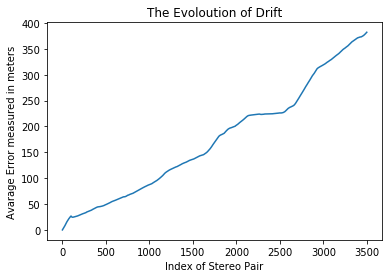

In [9]:
plt.plot(AvarageError[0:3500])
plt.xlabel('Index of Stereo Pair')
plt.ylabel('Avarage Error measured in meters')
plt.title('The Evoloution of Drift')

In [10]:
MaxError

NameError: name 'MaxError' is not defined